## overturning circulation in temp

In [167]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import cmocean as cm
from dask.distributed import Client
from collections import OrderedDict


In [2]:
client = Client(n_workers=4)
client

Client Scheduler: tcp://127.0.0.1:33933 Dashboard: /proxy/40757/status,Cluster Workers: 4 Cores: 8 Memory: 34.36 GB


In [3]:
expt = '1deg_jra55_ryf_RCPcont'
session = cc.database.create_session('/scratch/e14/cy8964/access-om2/archive/databases/1deg_jra55_ryf_experiments.db')
start_time='2900-01-31'
end_time = '2910-01-01'

In [4]:
psi = cc.querying.getvar(expt,'ty_trans_nrho',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time)#.isel(time = np.arange(40,50))
#psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',chunks={'potrho': None}, n=-10)
psi = psi.sum('grid_xt_ocean')

# ty_trans_nrho -> transport within temperature intervals 
# neutral_rho, neutral.
#

varlist = cc.querying.get_variables(session, expt)
if varlist['name'].str.contains('ty_trans_nrho_gm').any():
    GM = True
    psiGM = cc.querying.getvar(expt,'ty_trans_nrho_gm',session,start_time = start_time, end_time = end_time)#.isel(time = np.arange(40,50))
    psiGM = psiGM.sum('grid_xt_ocean')
    psisubmeso = cc.querying.getvar(expt,'ty_trans_nrho_submeso',session,start_time = start_time, end_time = end_time)#.isel(time = np.arange(40,50))
    psisubmeso = psisubmeso.sum('grid_xt_ocean')

else:
    GM = False

In [5]:
rho = 1025 # mean density of sea-water in kg/m^3
psi = psi / (1e6*rho) # converts kg/s to Sv
if GM:
    psiGM = psiGM / (1e6*rho)
    psisubmeso = psisubmeso / (1e6*rho)

In [6]:
psi_avg_cont = psi.cumsum('neutral').mean('time') - psi.sum('neutral').mean('time')
if GM:
    psi_avg_cont = psi_avg_cont + psiGM.mean('time')+ psisubmeso.mean('time')
    
psi_avg_cont.load()

<xarray.DataArray (neutral: 74, grid_yu_ocean: 300)>
array([[ 0.0000000e+00,  5.2867783e-03,  1.1512632e-02, ...,
         1.1411706e-02,  1.5875528e-02,  6.6347539e-08],
       [ 0.0000000e+00,  5.2867783e-03,  1.1512632e-02, ...,
         1.1411706e-02,  1.5875528e-02,  6.6347539e-08],
       [ 0.0000000e+00,  3.4108356e-01,  2.9121554e-01, ...,
        -1.7166778e-01, -7.2749920e-02, -7.7586961e-03],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)
Coordinates:
  * grid_yu_ocean  (grid_yu_ocean) float64 -77.75 -77.51 -77.26 ... 89.55 90.0
  * neutral        (neutral) float64 -2.75 -2.25 -1.75 ... 32.75 33.25 33.75

note doesn't do correct zonal averaging north of 65N

In [37]:
expt = '1deg_jra55_ryf_RCPcont'

SST_max = cc.querying.getvar(expt,'temp',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time).isel(st_ocean = 0).max('time').max('xt_ocean') -273.15#.isel(time = np.arange(40,50))
SST_min = cc.querying.getvar(expt,'temp',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time).isel(st_ocean = 0).min('time').min('xt_ocean') -273.15

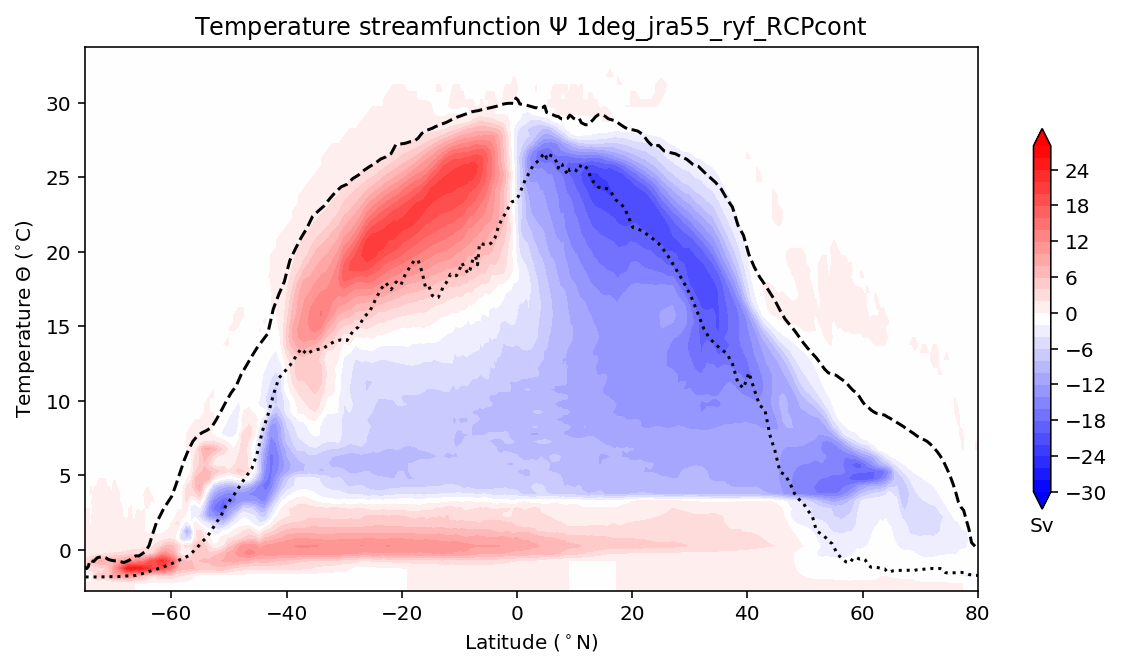

In [8]:
plt.figure(figsize=(10, 5)) 
clev = np.arange(-30,30,2)
plt.contourf(psi_avg_cont.grid_yu_ocean,psi_avg_cont.neutral, psi_avg_cont, cmap='bwr', levels=clev, extend='both')
cb=plt.colorbar(orientation='vertical', shrink = 0.7)
SST_min.plot(color = 'k', linestyle = 'dotted')
SST_max.plot(color = 'k', linestyle = '--')

cb.ax.set_xlabel('Sv')
#plt.contour(psi_avg_cont.grid_yu_ocean, psi_avg_cont.neutral, psi_avg_cont, levels=clev, colors='k', linewidths=0.25)
#plt.contour(psi_avg_cont.grid_yu_ocean, psi_avg_cont.neutral, psi_avg_cont, levels=[0.0,], colors='k', linewidths=0.5)
#plt.gca().invert_yaxis()

#plt.ylim((33.75,-2.75))
plt.ylabel('Temperature $\Theta $ ($^{\circ}$C)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75,80])
plt.title('Temperature streamfunction $\Psi$ %s' % expt);
#plt.savefig('figures/overturning')

Now calculate internal heat function  $\mathcal{A}_I(\phi, \Theta, t)=\rho_0C_p \int_{-\infty }^{\Theta} \Psi d\Theta ' + \mathcal{A}_D$?

rho_0*c_p*psi_avg_cont.cumsum('neutral')

Need to also mask out where sea surface stops so we don't cumsum over air

In [13]:
SST_max2 = cc.querying.getvar(expt,'temp',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time).isel(st_ocean = 0).max('time').max('xt_ocean') -273.15#.isel(time = np.arange(40,50))
SST_max2.coords['yt_ocean'] = psi_avg_cont.grid_yu_ocean.values
SST_max2 = SST_max2.rename({'yt_ocean':'grid_yu_ocean'})
SST_mean = cc.querying.getvar(expt,'temp',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time).isel(st_ocean = 0).mean('time').mean('xt_ocean') -273.15#.isel(time = np.arange(40,50))
SST_mean.coords['yt_ocean'] = psi_avg_cont.grid_yu_ocean.values
SST_mean = SST_mean.rename({'yt_ocean':'grid_yu_ocean'})

In [14]:
rho_0 = 1030#kg/m^3
c_p = 3992 
A_I = -rho_0*c_p*psi_avg_cont.cumsum('neutral')*0.5 #(0.5 is size of d\theta)
A_I = A_I/10**9 # convert to PW
A_I = A_I.where(A_I.neutral < SST_max2).fillna(0)

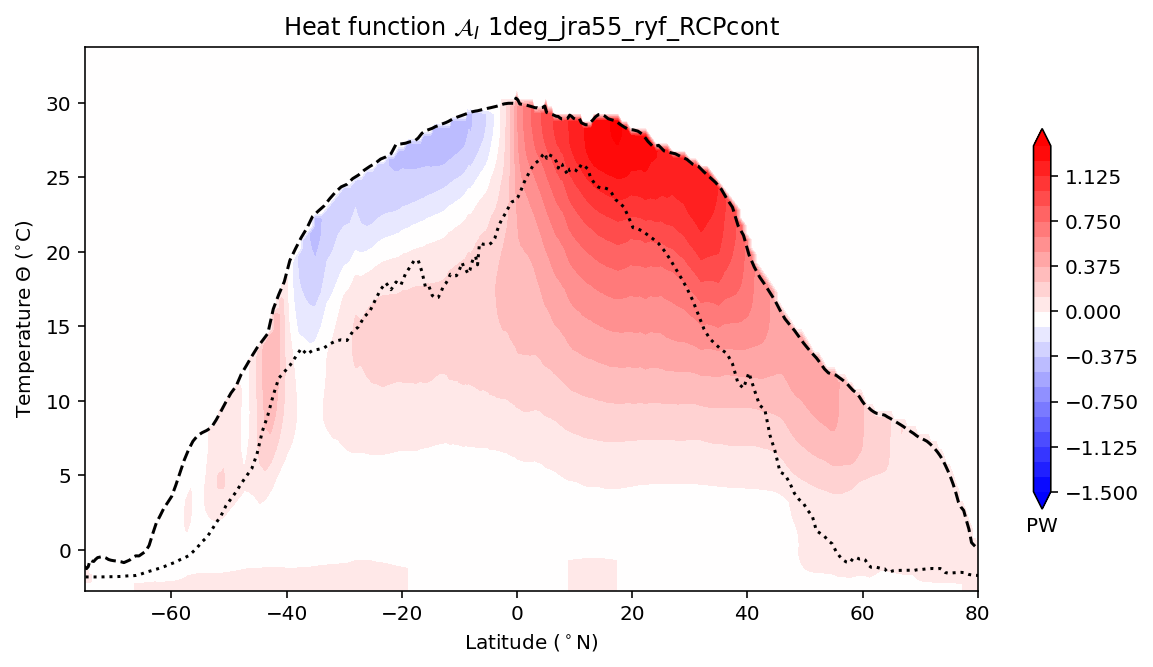

In [15]:
plt.figure(figsize=(10, 5)) 
clev = np.arange(-1.5,1.5,0.125)
plt.contourf(A_I.grid_yu_ocean,A_I.neutral, A_I, cmap='bwr', levels=clev, extend='both')
SST_min.plot(color = 'k', linestyle = 'dotted')
SST_max.plot(color = 'k', linestyle = '--')
cb=plt.colorbar(orientation='vertical', shrink = 0.7)
    
cb.ax.set_xlabel('PW')
clev2 = np.arange(-1.5,1.5,0.25)
#plt.contour(A_I.grid_yu_ocean, A_I.neutral, A_I, levels=clev2, colors='k', linewidths=0.25)
#plt.contour(psi_avg_cont.grid_yu_ocean, psi_avg_cont.neutral, psi_avg_cont, levels=[0.0,], colors='k', linewidths=0.5)
#plt.gca().invert_yaxis()

#plt.ylim((33.75,-2.75))
plt.ylabel('Temperature $\Theta $ ($^{\circ}$C)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75,80])
plt.title('Heat function $\mathcal{A}_I$ %s' % expt);
#plt.savefig('figures/overturning')

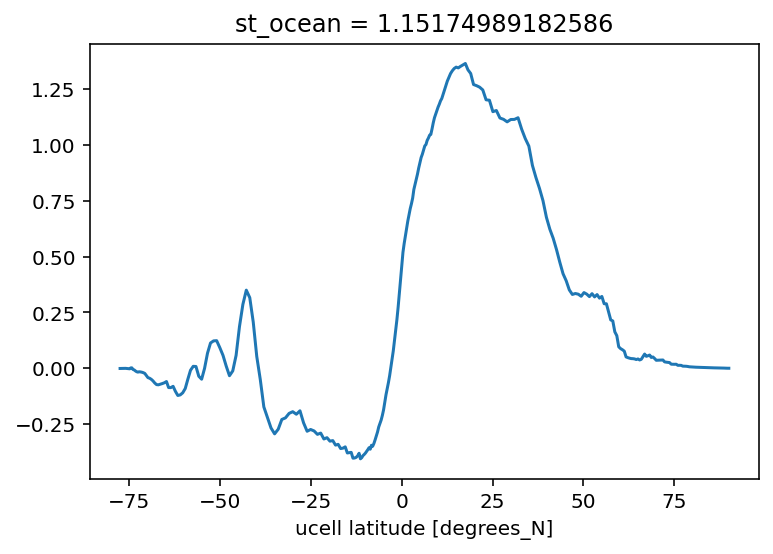

In [16]:
A_I_m = A_I.where(A_I.neutral > SST_mean-0.25).where(A_I.neutral < SST_mean+0.25).mean('neutral').plot()#.fillna(0)

instead mask by streamfunction

In [38]:
rho_0 = 1030#kg/m^3
c_p = 3992 
A_I = -rho_0*c_p*psi_avg_cont.cumsum('neutral')*0.5 #(0.5 is size of d\theta)
A_I = A_I/10**9 # convert to PW
A_I_c = A_I
A_I = A_I.where(psi_avg_cont !=0).fillna(0)

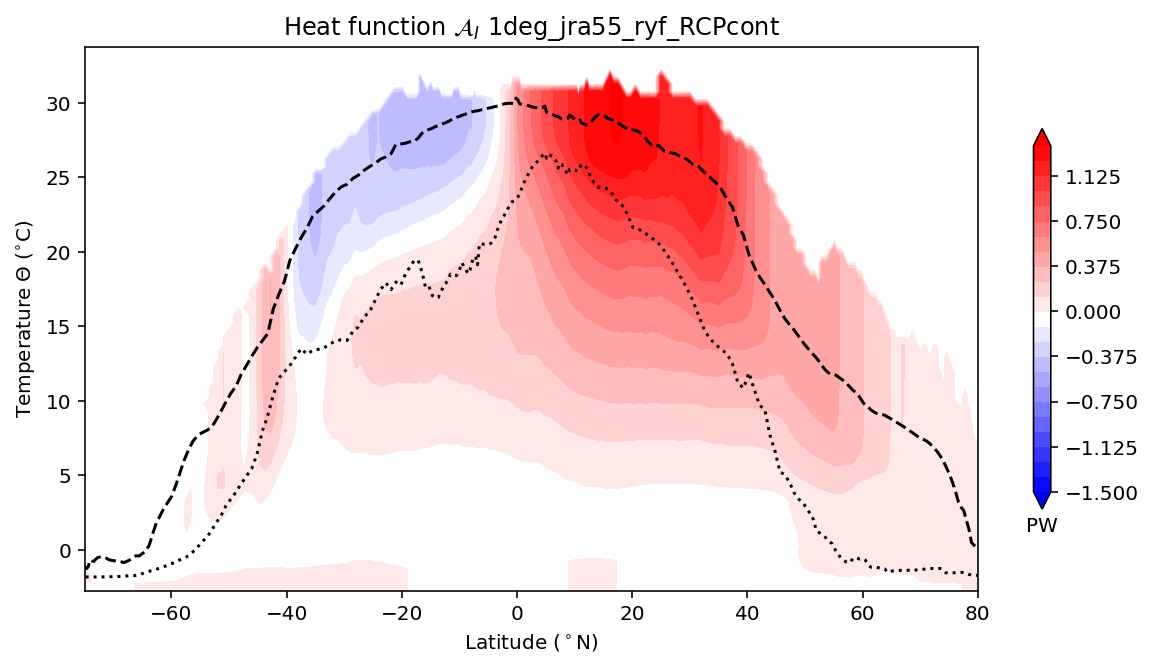

In [22]:
plt.figure(figsize=(10, 5)) 
clev = np.arange(-1.5,1.5,0.125)
plt.contourf(A_I.grid_yu_ocean,A_I.neutral, A_I, cmap='bwr', levels=clev, extend='both')
SST_min.plot(color = 'k', linestyle = 'dotted')
SST_max.plot(color = 'k', linestyle = '--')
cb=plt.colorbar(orientation='vertical', shrink = 0.7)
    
cb.ax.set_xlabel('PW')
clev2 = np.arange(-1.5,1.5,0.25)
#plt.contour(A_I.grid_yu_ocean, A_I.neutral, A_I, levels=clev2, colors='k', linewidths=0.25)
#plt.contour(psi_avg_cont.grid_yu_ocean, psi_avg_cont.neutral, psi_avg_cont, levels=[0.0,], colors='k', linewidths=0.5)
#plt.gca().invert_yaxis()

#plt.ylim((33.75,-2.75))
plt.ylabel('Temperature $\Theta $ ($^{\circ}$C)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75,80])
plt.title('Heat function $\mathcal{A}_I$ %s' % expt);
#plt.savefig('figures/overturning')

# Anomalies (v2)

In [86]:
expt = '1deg_jra55_ryf_RCPwarmhumid'
start_time='2910-01-31'
end_time = '2950-01-01'

psi = cc.querying.getvar(expt,'ty_trans_nrho',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time)#.isel(time = np.arange(40,50))
#psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',chunks={'potrho': None}, n=-10)
psi = psi.sum('grid_xt_ocean')

# ty_trans_nrho -> transport within temperature intervals 
# neutral_rho, neutral.
#

varlist = cc.querying.get_variables(session, expt)
if varlist['name'].str.contains('ty_trans_nrho_gm').any():
    GM = True
    psiGM = cc.querying.getvar(expt,'ty_trans_nrho_gm',session,start_time = start_time, end_time = end_time)#.isel(time = np.arange(40,50))
    psiGM = psiGM.sum('grid_xt_ocean')
    psisubmeso = cc.querying.getvar(expt,'ty_trans_nrho_submeso',session,start_time = start_time, end_time = end_time)#.isel(time = np.arange(40,50))
    psisubmeso = psisubmeso.sum('grid_xt_ocean')

else:
    GM = False
    
rho = 1025 # mean density of sea-water in kg/m^3
psi = psi / (1e6*rho) # converts kg/s to Sv
if GM:
    psiGM = psiGM / (1e6*rho)
    psisubmeso = psisubmeso / (1e6*rho)
    

psi_avg_warm = psi.cumsum('neutral').mean('time') - psi.sum('neutral').mean('time')
if GM:
    psi_avg_warm = psi_avg_warm + psiGM.mean('time')+ psisubmeso.mean('time')
    
psi_avg_warm.load()


SST_max_w = cc.querying.getvar(expt,'temp',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time).isel(st_ocean = 0).max('time').max('xt_ocean') -273.15#.isel(time = np.arange(40,50))
SST_min_w = cc.querying.getvar(expt,'temp',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time).isel(st_ocean = 0).min('time').min('xt_ocean') -273.15
    
    

rho_0 = 1030#kg/m^3
c_p = 3992 
A_I_w = -rho_0*c_p*psi_avg_warm.cumsum('neutral')*0.5 #(0.5 is size of d\theta)
A_I_w = A_I_w/10**9 # convert to PW
A_I_wa = (A_I_w-A_I_c).where(psi_avg_warm !=0).fillna(0)


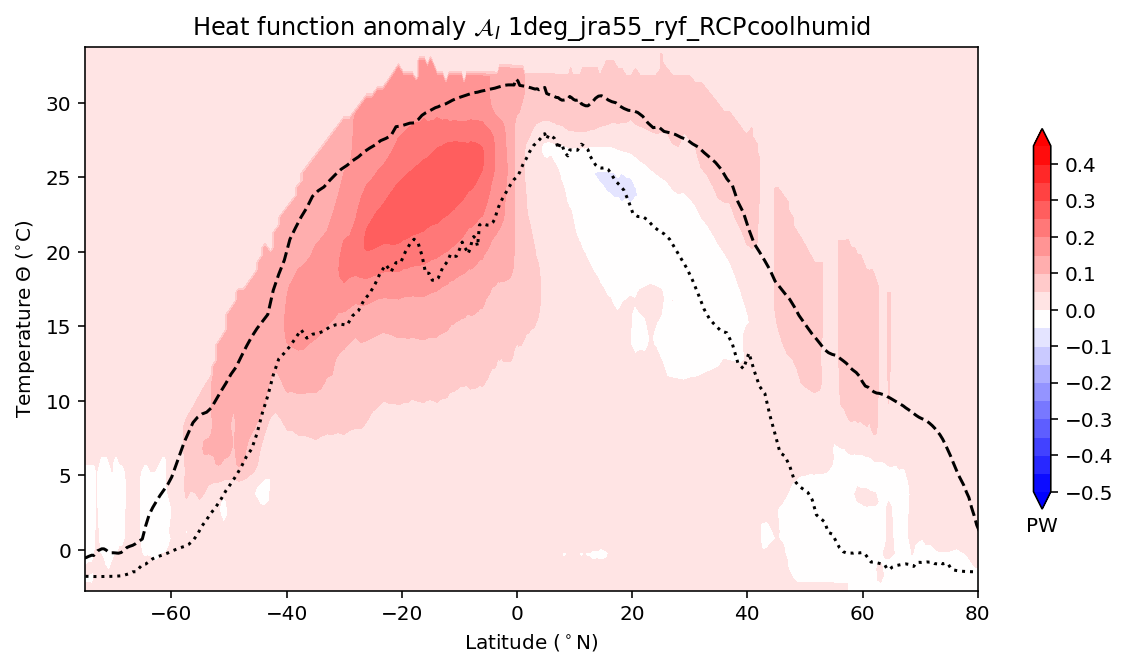

In [59]:
plt.figure(figsize=(10, 5)) 
clev = np.arange(-0.5,0.5,0.05)
plt.contourf((A_I_w-A_I_c).grid_yu_ocean,(A_I_w-A_I_c).neutral, (A_I_w-A_I_c), cmap='bwr', levels=clev, extend='both')
SST_min_w.plot(color = 'k', linestyle = 'dotted')
SST_max_w.plot(color = 'k', linestyle = '--')
cb=plt.colorbar(orientation='vertical', shrink = 0.7)
    
cb.ax.set_xlabel('PW')
clev2 = np.arange(-0.5,0.5,0.05)
#plt.contour(A_I.grid_yu_ocean, A_I.neutral, A_I, levels=clev2, colors='k', linewidths=0.25)
#plt.contour(psi_avg_cont.grid_yu_ocean, psi_avg_cont.neutral, psi_avg_cont, levels=[0.0,], colors='k', linewidths=0.5)
#plt.gca().invert_yaxis()

#plt.ylim((33.75,-2.75))
plt.ylabel('Temperature $\Theta $ ($^{\circ}$C)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75,80])
plt.title('Heat function anomaly $\mathcal{A}_I$ %s' % expt);
#plt.savefig('figures/overturning')

# missing first 10years for warmhumid

In [75]:
expt = '1deg_jra55_ryf_RCPcoolhumid'
start_time='2910-01-31'
end_time = '2950-01-01'

psi = cc.querying.getvar(expt,'ty_trans_nrho',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time)#.isel(time = np.arange(40,50))
#psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',chunks={'potrho': None}, n=-10)
psi = psi.sum('grid_xt_ocean')

# ty_trans_nrho -> transport within temperature intervals 
# neutral_rho, neutral.
#

varlist = cc.querying.get_variables(session, expt)
if varlist['name'].str.contains('ty_trans_nrho_gm').any():
    GM = True
    psiGM = cc.querying.getvar(expt,'ty_trans_nrho_gm',session,start_time = start_time, end_time = end_time)#.isel(time = np.arange(40,50))
    psiGM = psiGM.sum('grid_xt_ocean')
    psisubmeso = cc.querying.getvar(expt,'ty_trans_nrho_submeso',session,start_time = start_time, end_time = end_time)#.isel(time = np.arange(40,50))
    psisubmeso = psisubmeso.sum('grid_xt_ocean')

else:
    GM = False
    
rho = 1025 # mean density of sea-water in kg/m^3
psi = psi / (1e6*rho) # converts kg/s to Sv
if GM:
    psiGM = psiGM / (1e6*rho)
    psisubmeso = psisubmeso / (1e6*rho)
    

psi_avg_cool = psi.cumsum('neutral').mean('time') - psi.sum('neutral').mean('time')
if GM:
    psi_avg_cool = psi_avg_cool + psiGM.mean('time')+ psisubmeso.mean('time')
    
psi_avg_cool.load()


SST_max_co = cc.querying.getvar(expt,'temp',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time).isel(st_ocean = 0).max('time').max('xt_ocean') -273.15#.isel(time = np.arange(40,50))
SST_min_co = cc.querying.getvar(expt,'temp',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time).isel(st_ocean = 0).min('time').min('xt_ocean') -273.15
    
    

rho_0 = 1030#kg/m^3
c_p = 3992 
A_I_co = -rho_0*c_p*psi_avg_cool.cumsum('neutral')*0.5 #(0.5 is size of d\theta)
A_I_co = A_I_co/10**9 # convert to PW
A_I_coa= (A_I_co-A_I_c).where(psi_avg_cool!=0).fillna(0)

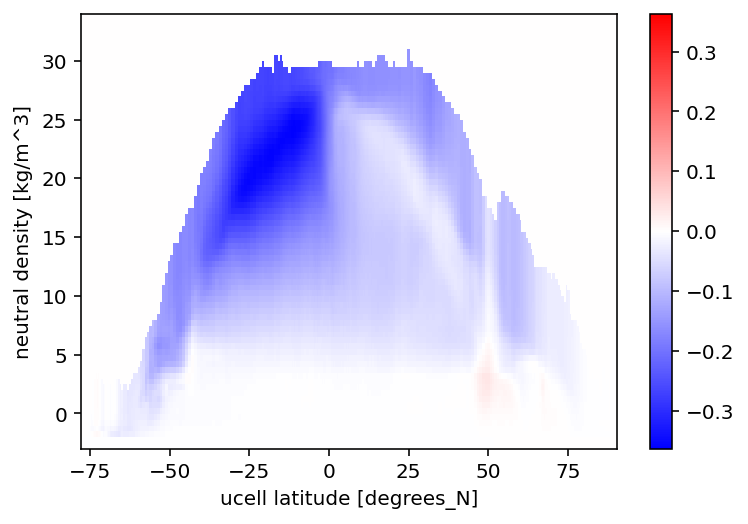

In [78]:
A_I_coa.plot(cmap = 'bwr')

In [76]:
A_I_coa.values

array([[ 0.00000000e+00, -1.11709663e-06, -1.92837364e-06, ...,
         1.36108009e-05,  6.97192654e-06,  1.91752847e-10],
       [ 0.00000000e+00, -2.23419326e-06, -3.85674728e-06, ...,
         2.72216017e-05,  1.39438531e-05,  3.83505695e-10],
       [ 0.00000000e+00,  1.47262564e-04,  1.83387416e-04, ...,
         4.86014154e-05,  4.93094132e-05,  3.29978729e-05],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

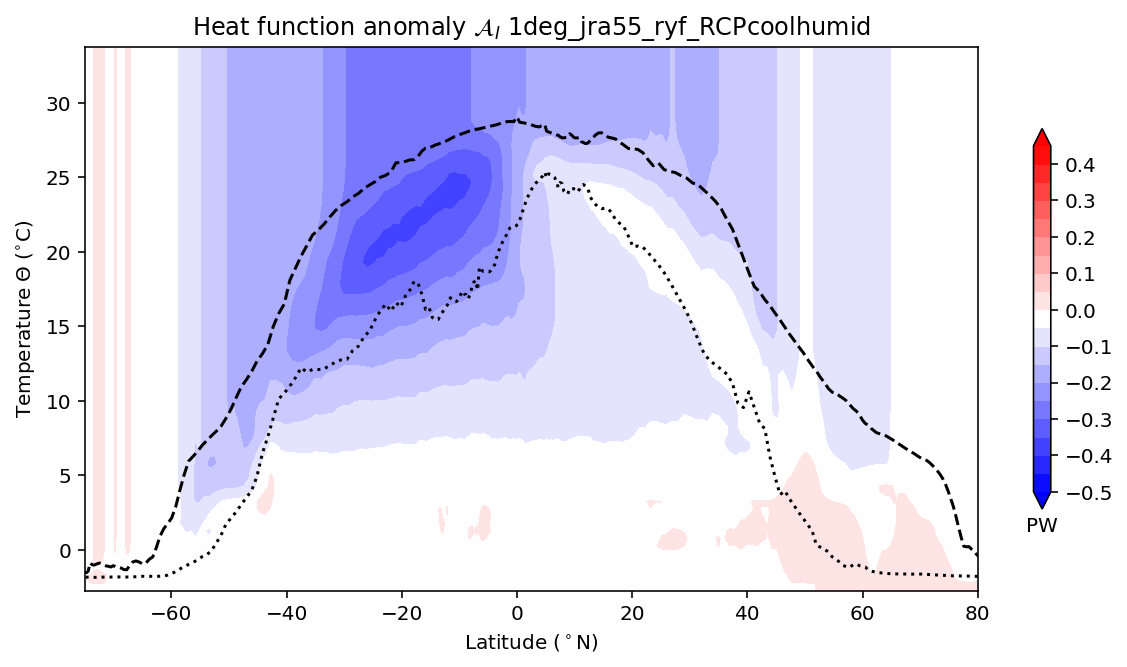

In [36]:
plt.figure(figsize=(10, 5)) 
clev = np.arange(-0.5,0.5,0.05)
plt.contourf((A_I_co-A_I_c).grid_yu_ocean,(A_I_co-A_I_c).neutral, (A_I_co-A_I_c), cmap='bwr', levels=clev, extend='both')
SST_min_co.plot(color = 'k', linestyle = 'dotted')
SST_max_co.plot(color = 'k', linestyle = '--')
cb=plt.colorbar(orientation='vertical', shrink = 0.7)
    
cb.ax.set_xlabel('PW')
clev2 = np.arange(-0.5,0.5,0.05)
#plt.contour(A_I.grid_yu_ocean, A_I.neutral, A_I, levels=clev2, colors='k', linewidths=0.25)
#plt.contour(psi_avg_cont.grid_yu_ocean, psi_avg_cont.neutral, psi_avg_cont, levels=[0.0,], colors='k', linewidths=0.5)
#plt.gca().invert_yaxis()

#plt.ylim((33.75,-2.75))
plt.ylabel('Temperature $\Theta $ ($^{\circ}$C)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75,80])
plt.title('Heat function anomaly $\mathcal{A}_I$ %s' % expt);
#plt.savefig('figures/overturning')

In [93]:
def custom_div_cmap(numcolors=21, name='custom_div_cmap',
                    mincol='blue', midcol='white', maxcol='red'):
    """ Create a custom diverging colormap with three colors
    
    Default is blue to white to red with 11 colors.  Colors can be specified
    in any way understandable by matplotlib.colors.ColorConverter.to_rgb()
    """

    from matplotlib.colors import LinearSegmentedColormap 
    
    cmap = LinearSegmentedColormap.from_list(name=name, 
                                             colors =[mincol, midcol, maxcol],
                                             N=numcolors)
    return cmap


In [102]:
bwr_custom = custom_div_cmap(17)

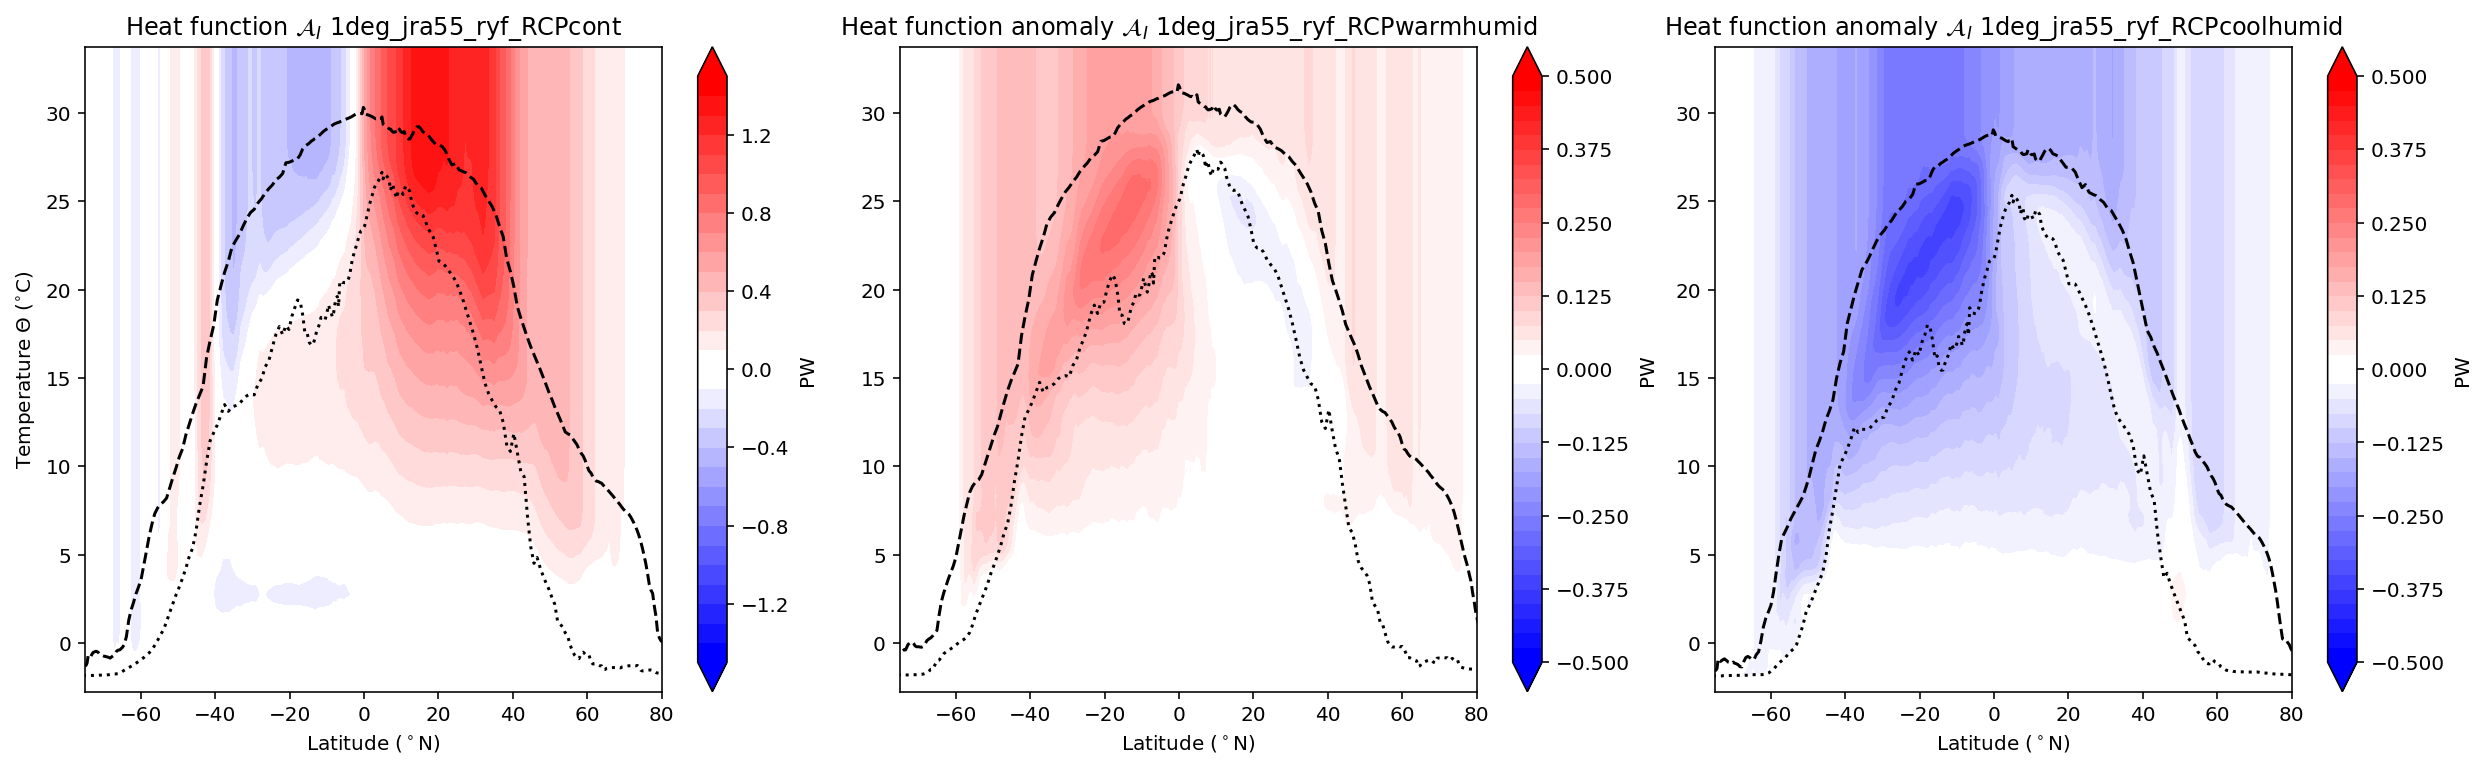

In [133]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize = (20,6))

expt = '1deg_jra55_ryf_RCPcont'
bwr_custom = custom_div_cmap(29)
clev = np.linspace(-1.5,1.5,31)
#clev = np.arange(-1.5,1.51,0.125)
cs = axes[0].contourf(A_I_c.grid_yu_ocean,A_I_c.neutral, A_I_c, cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True)
SST_min.plot(color = 'k', linestyle = 'dotted', ax = axes[0])
SST_max.plot(color = 'k', linestyle = '--', ax = axes[0])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
axes[0].set_ylabel('Temperature $\Theta $ ($^{\circ}$C)')
axes[0].set_xlabel('Latitude ($^\circ$N)')
axes[0].set_xlim([-75,80])
axes[0].set_title('Heat function $\mathcal{A}_I$ %s' % expt);
fig.colorbar(cs, ax=axes[0], label = 'PW')
#plt.savefig('figures/overturning')

expt = '1deg_jra55_ryf_RCPwarmhumid'
bwr_custom = custom_div_cmap(39)
clev = np.linspace(-0.5,0.5,41)

#clev = np.arange(-0.5,0.51,0.05)
cs2 = axes[1].contourf((A_I_w-A_I_c).grid_yu_ocean,(A_I_w-A_I_c).neutral, (A_I_w-A_I_c), cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True)
SST_min_w.plot(color = 'k', linestyle = 'dotted', ax = axes[1])
SST_max_w.plot(color = 'k', linestyle = '--', ax = axes[1])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
axes[1].set_ylabel('')
axes[1].set_xlabel('Latitude ($^\circ$N)')
axes[1].set_xlim([-75,80])
axes[1].set_title('Heat function anomaly $\mathcal{A}_I$ %s' % expt);
fig.colorbar(cs2, ax=axes[1], label = 'PW')

expt = '1deg_jra55_ryf_RCPcoolhumid'

#clev = np.arange(-0.5,0.51,0.05)
cs3 = axes[2].contourf((A_I_co-A_I_c).grid_yu_ocean,(A_I_co-A_I_c).neutral, (A_I_co-A_I_c), cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True)
SST_min_co.plot(color = 'k', linestyle = 'dotted', ax = axes[2])
SST_max_co.plot(color = 'k', linestyle = '--', ax = axes[2])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
axes[2].set_ylabel('')
axes[2].set_xlabel('Latitude ($^\circ$N)')
axes[2].set_xlim([-75,80])
axes[2].set_title('Heat function anomaly $\mathcal{A}_I$ %s' % expt);
fig.colorbar(cs3, ax=axes[2], label = 'PW')


# cb_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
# cbar = fig.colorbar(CS, cax=cb_ax, cmap = cm.cm.balance)
# cbar.ax.set_ylabel('heat anomaly ($Jm^{-2}$)', fontsize = 16)
plt.tight_layout()
plt.subplots_adjust(top=0.85, right = 0.85, hspace = 0.25)

can see both northward and southward transport of heat in control as expected. The warming anomaly is red at the surface, implies heat transport increases in northward direction in both hemispheres, and cooling anomaly implies more southward heat transport. Consistent with meridional heat transport plots

streamfunc anomaly shows strengthening of AMOC in warming experiment.

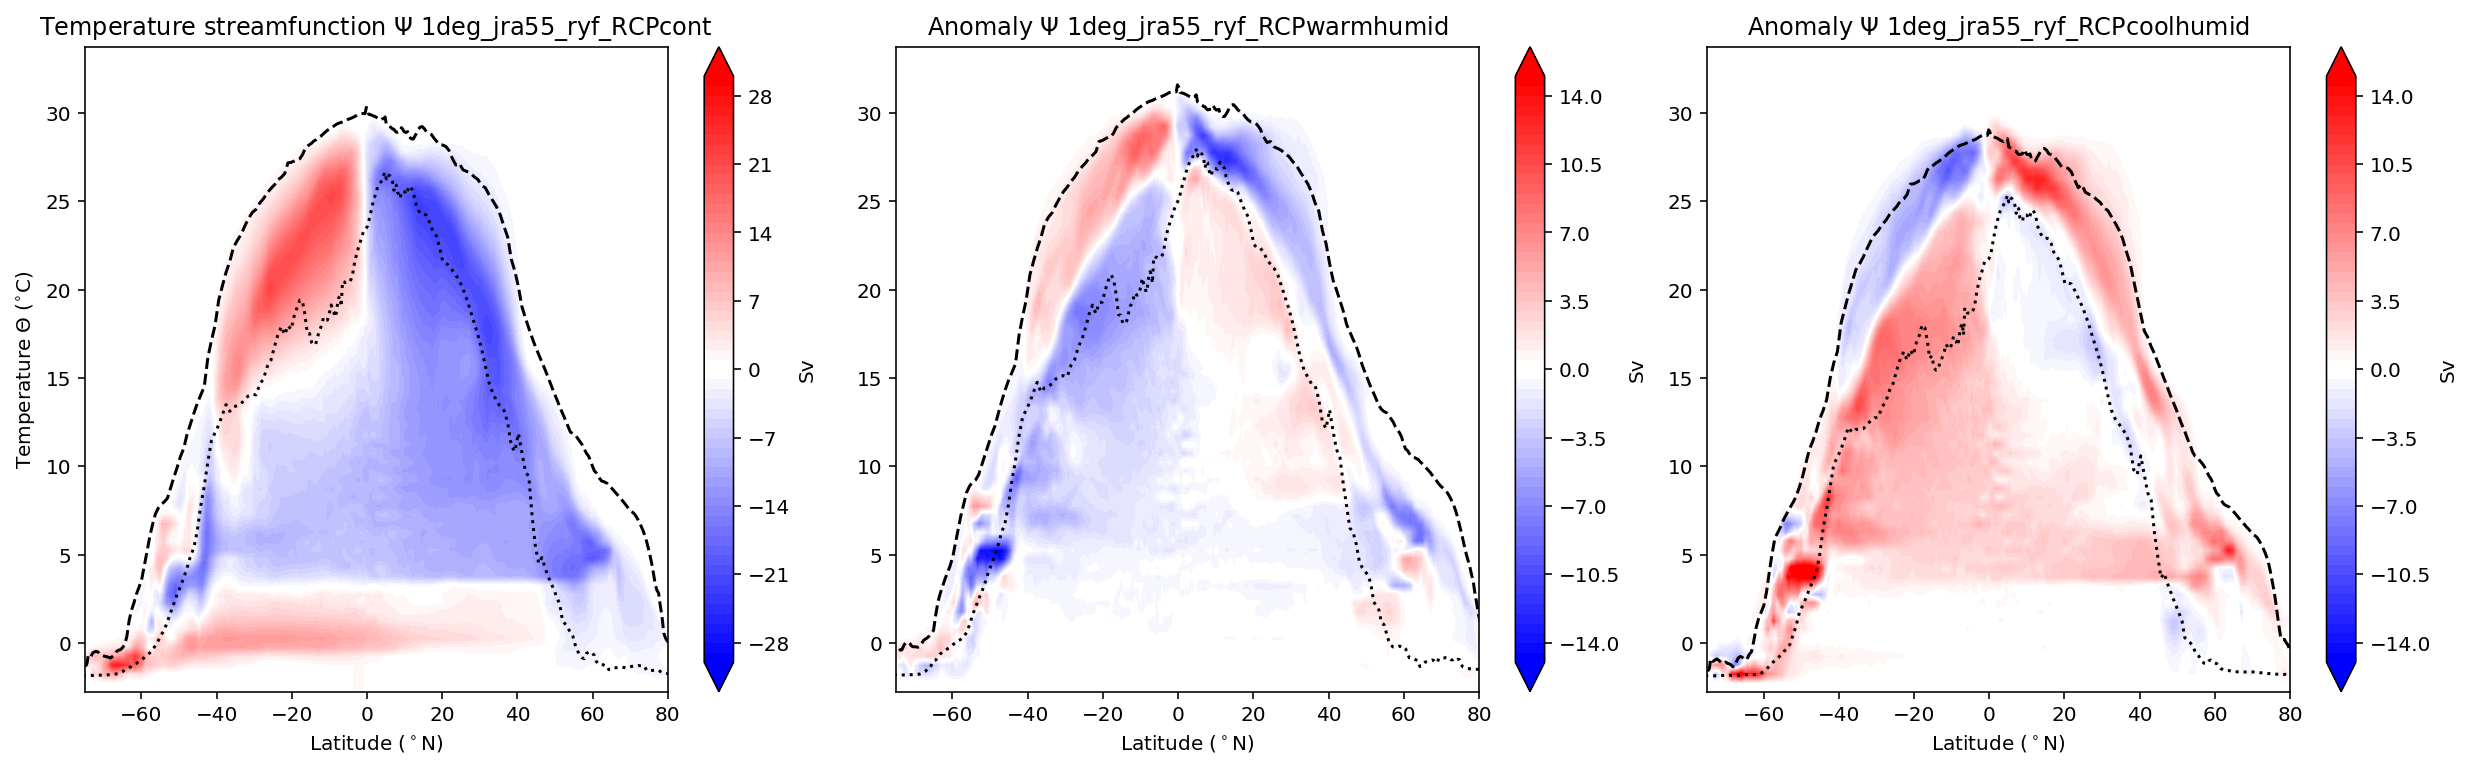

In [132]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize = (20,6))

expt = '1deg_jra55_ryf_RCPcont'
n=21
bwr_custom = custom_div_cmap(59)
clev = np.linspace(-30,30,61)
#clev = np.arange(-1.5,1.55,0.125)
cs = axes[0].contourf(psi_avg_cont.grid_yu_ocean,psi_avg_cont.neutral, psi_avg_cont, cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True)
SST_min.plot(color = 'k', linestyle = 'dotted', ax = axes[0])
SST_max.plot(color = 'k', linestyle = '--', ax = axes[0])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
axes[0].set_ylabel('Temperature $\Theta $ ($^{\circ}$C)')
axes[0].set_xlabel('Latitude ($^\circ$N)')
axes[0].set_xlim([-75,80])
axes[0].set_title('Temperature streamfunction $\Psi$ %s' % expt);
fig.colorbar(cs, ax=axes[0], label = 'Sv')
#plt.savefig('figures/overturning')
bwr_custom = custom_div_cmap(19)
expt = '1deg_jra55_ryf_RCPwarmhumid'

#clev = np.arange(-0.5,0.52,0.05)
bwr_custom = custom_div_cmap(59)
clev = np.linspace(-15,15,61)
cs2 = axes[1].contourf((psi_avg_warm-psi_avg_cont).grid_yu_ocean,(psi_avg_warm-psi_avg_cont).neutral, (psi_avg_warm-psi_avg_cont), cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True)
SST_min_w.plot(color = 'k', linestyle = 'dotted', ax = axes[1])
SST_max_w.plot(color = 'k', linestyle = '--', ax = axes[1])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
axes[1].set_ylabel('')
axes[1].set_xlabel('Latitude ($^\circ$N)')
axes[1].set_xlim([-75,80])
axes[1].set_title('Anomaly $\Psi$ %s' % expt);
fig.colorbar(cs2, ax=axes[1], label = 'Sv')

expt = '1deg_jra55_ryf_RCPcoolhumid'

#clev = np.arange(-0.5,0.52,0.05)
cs3 = axes[2].contourf((psi_avg_cool-psi_avg_cont).grid_yu_ocean,(psi_avg_cool-psi_avg_cont).neutral, (psi_avg_cool-psi_avg_cont), cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True, vcenter=0)
SST_min_co.plot(color = 'k', linestyle = 'dotted', ax = axes[2])
SST_max_co.plot(color = 'k', linestyle = '--', ax = axes[2])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
axes[2].set_ylabel('')
axes[2].set_xlabel('Latitude ($^\circ$N)')
axes[2].set_xlim([-75,80])
axes[2].set_title('Anomaly $\Psi$ %s' % expt);
fig.colorbar(cs3, ax=axes[2], label = 'Sv')


# cb_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
# cbar = fig.colorbar(CS, cax=cb_ax, cmap = cm.cm.balance)
# cbar.ax.set_ylabel('heat anomaly ($Jm^{-2}$)', fontsize = 16)
plt.tight_layout()
plt.subplots_adjust(top=0.85, right = 0.85, hspace = 0.25)

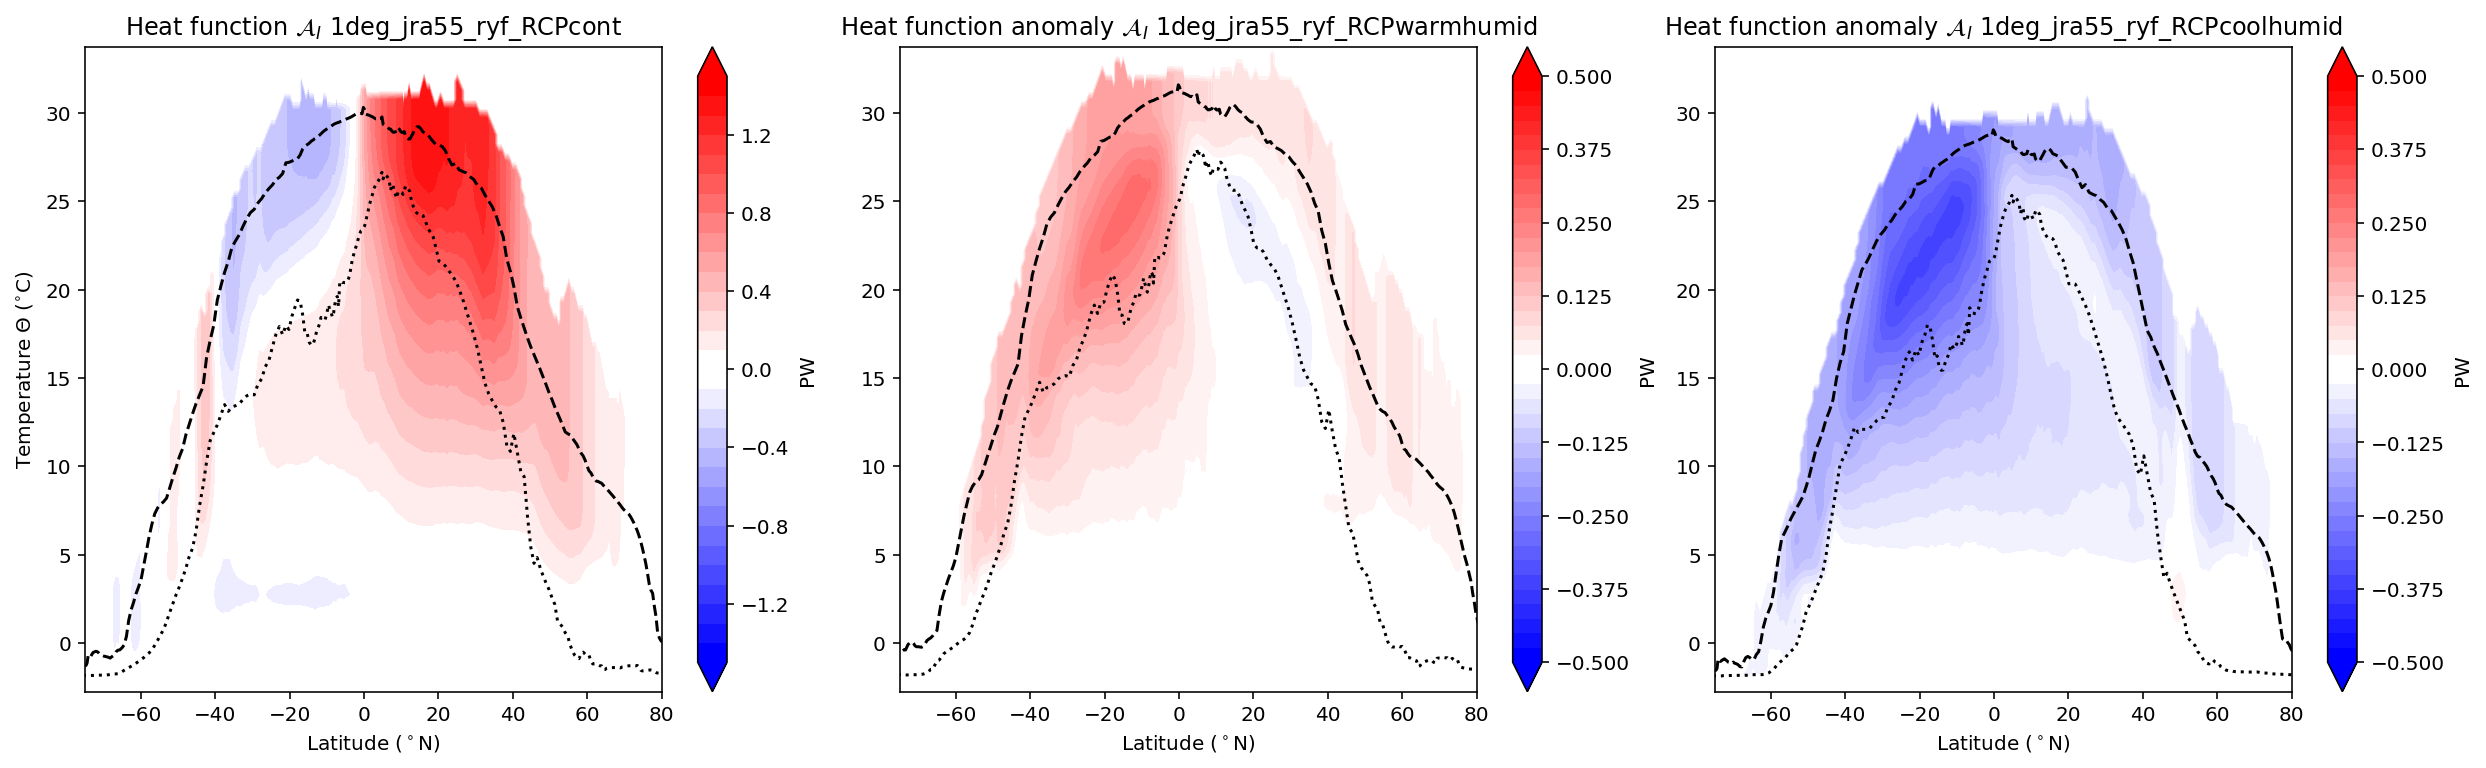

In [123]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize = (20,6))

expt = '1deg_jra55_ryf_RCPcont'
n=21
bwr_custom = custom_div_cmap(29)
clev = np.linspace(-1.5,1.5,31)
#clev = np.arange(-1.5,1.55,0.125)
cs = axes[0].contourf(A_I.grid_yu_ocean,A_I.neutral, A_I, cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True)
SST_min.plot(color = 'k', linestyle = 'dotted', ax = axes[0])
SST_max.plot(color = 'k', linestyle = '--', ax = axes[0])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
axes[0].set_ylabel('Temperature $\Theta $ ($^{\circ}$C)')
axes[0].set_xlabel('Latitude ($^\circ$N)')
axes[0].set_xlim([-75,80])
axes[0].set_title('Heat function $\mathcal{A}_I$ %s' % expt);
fig.colorbar(cs, ax=axes[0], label = 'PW')
#plt.savefig('figures/overturning')
bwr_custom = custom_div_cmap(19)
expt = '1deg_jra55_ryf_RCPwarmhumid'

#clev = np.arange(-0.5,0.52,0.05)
bwr_custom = custom_div_cmap(39)
clev = np.linspace(-0.5,0.5,41)
cs2 = axes[1].contourf((A_I_wa).grid_yu_ocean,(A_I_wa).neutral, (A_I_wa), cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True)
SST_min_w.plot(color = 'k', linestyle = 'dotted', ax = axes[1])
SST_max_w.plot(color = 'k', linestyle = '--', ax = axes[1])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
axes[1].set_ylabel('')
axes[1].set_xlabel('Latitude ($^\circ$N)')
axes[1].set_xlim([-75,80])
axes[1].set_title('Heat function anomaly $\mathcal{A}_I$ %s' % expt);
fig.colorbar(cs2, ax=axes[1], label = 'PW')

expt = '1deg_jra55_ryf_RCPcoolhumid'

#clev = np.arange(-0.5,0.52,0.05)
cs3 = axes[2].contourf((A_I_coa).grid_yu_ocean,(A_I_coa).neutral, (A_I_coa), cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True, vcenter=0)
SST_min_co.plot(color = 'k', linestyle = 'dotted', ax = axes[2])
SST_max_co.plot(color = 'k', linestyle = '--', ax = axes[2])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
axes[2].set_ylabel('')
axes[2].set_xlabel('Latitude ($^\circ$N)')
axes[2].set_xlim([-75,80])
axes[2].set_title('Heat function anomaly $\mathcal{A}_I$ %s' % expt);
fig.colorbar(cs3, ax=axes[2], label = 'PW')


# cb_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
# cbar = fig.colorbar(CS, cax=cb_ax, cmap = cm.cm.balance)
# cbar.ax.set_ylabel('heat anomaly ($Jm^{-2}$)', fontsize = 16)
plt.tight_layout()
plt.subplots_adjust(top=0.85, right = 0.85, hspace = 0.25)

# mask basin

In [134]:
expt = '1deg_jra55_ryf_RCPcont'
ht = cc.querying.getvar(expt,'ht',session,n=-1)
land_mask = ~ht.isnull()

south_map = (land_mask.where(land_mask.yt_ocean < -34)).fillna(0) 
indo_map1 = (land_mask.where(land_mask.yt_ocean < 9).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-65)).fillna(0) 
indo_map2 = (land_mask.where(land_mask.yt_ocean < 15).where(land_mask.yt_ocean > 9).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-83.7)).fillna(0) 
indo_map3 = (land_mask.where(land_mask.yt_ocean < 17).where(land_mask.yt_ocean > 15).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-93.3)).fillna(0) 
indo_map4 = (land_mask.where(land_mask.yt_ocean < 85).where(land_mask.yt_ocean > 17).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-99)).fillna(0) 
indo_map5 = (land_mask.where(land_mask.yt_ocean < 30.5).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean >25).where(land_mask.xt_ocean<80)).fillna(0) 
indo_sector_map = indo_map1 + indo_map2 + indo_map3 + indo_map4 + indo_map5 + south_map
indo_sector_mask = indo_sector_map.where(indo_sector_map>0)
atlantic_sector_map = (indo_sector_mask * 0).fillna(1) * land_mask
atlantic_sector_map = atlantic_sector_map + south_map
atlantic_sector_mask = atlantic_sector_map.where(atlantic_sector_map>0)

In [135]:
south_map = (land_mask.where(land_mask.yt_ocean < -34)).fillna(0) 
indo_map1 = (land_mask.where(land_mask.yt_ocean < 9).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-65)).fillna(0) 
indo_map2 = (land_mask.where(land_mask.yt_ocean < 15).where(land_mask.yt_ocean > 9).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-83.7)).fillna(0) 
indo_map3 = (land_mask.where(land_mask.yt_ocean < 17).where(land_mask.yt_ocean > 15).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-93.3)).fillna(0) 
indo_map4 = (land_mask.where(land_mask.yt_ocean < 85).where(land_mask.yt_ocean > 17).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-99)).fillna(0) 
indo_map5 = (land_mask.where(land_mask.yt_ocean < 30.5).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean >25).where(land_mask.xt_ocean<80)).fillna(0) 
indo_sector_map = indo_map1 + indo_map2 + indo_map3 + indo_map4 + indo_map5 + south_map
indo_sector_mask = indo_sector_map.where(indo_sector_map>0)
atlantic_sector_map = (indo_sector_mask * 0).fillna(1) * land_mask
atlantic_sector_map = atlantic_sector_map + south_map
atlantic_sector_mask = atlantic_sector_map.where(atlantic_sector_map>0)

psi = cc.querying.getvar(expt,'ty_trans_rho',session, n=1) ## needs to be the same coordinates as what you want to mask
atlantic_sector_mask.coords['xt_ocean'] = psi.grid_xt_ocean.values
atlantic_sector_mask.coords['yt_ocean'] = psi.grid_yu_ocean.values
atlantic_sector_mask = atlantic_sector_mask.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yu_ocean'})
indo_sector_mask.coords['xt_ocean'] = psi.grid_xt_ocean.values
indo_sector_mask.coords['yt_ocean'] = psi.grid_yu_ocean.values
indo_sector_mask = indo_sector_mask.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yu_ocean'})



# Atlantic

In [151]:
expt = '1deg_jra55_ryf_RCPcont'
start_time='2910-01-31'
end_time = '2950-01-01'

psi = cc.querying.getvar(expt,'ty_trans_nrho',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time)
psi = psi*atlantic_sector_mask#.isel(time = np.arange(40,50))
#psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',chunks={'potrho': None}, n=-10)
psi = psi.sum('grid_xt_ocean')

# ty_trans_nrho -> transport within temperature intervals 
# neutral_rho, neutral.
#

varlist = cc.querying.get_variables(session, expt)
if varlist['name'].str.contains('ty_trans_nrho_gm').any():
    GM = True
    psiGM = cc.querying.getvar(expt,'ty_trans_nrho_gm',session,start_time = start_time, end_time = end_time)#.isel(time = np.arange(40,50))
    psiGM = (psiGM*atlantic_sector_mask).sum('grid_xt_ocean')
    psisubmeso = cc.querying.getvar(expt,'ty_trans_nrho_submeso',session,start_time = start_time, end_time = end_time)#.isel(time = np.arange(40,50))
    psisubmeso = (psisubmeso*atlantic_sector_mask).sum('grid_xt_ocean')

else:
    GM = False
    
rho = 1025 # mean density of sea-water in kg/m^3
psi = psi / (1e6*rho) # converts kg/s to Sv
if GM:
    psiGM = psiGM / (1e6*rho)
    psisubmeso = psisubmeso / (1e6*rho)
    

psi_avg_contatlantic = psi.cumsum('neutral').mean('time') - psi.sum('neutral').mean('time')
if GM:
    psi_avg_contatlantic = psi_avg_contatlantic + psiGM.mean('time')+ psisubmeso.mean('time')
    
psi_avg_contatlantic.load()


SST_max_contatlantic = cc.querying.getvar(expt,'temp',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time).isel(st_ocean = 0).max('time').max('xt_ocean') -273.15#.isel(time = np.arange(40,50))
SST_min_contatlantic = cc.querying.getvar(expt,'temp',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time).isel(st_ocean = 0).min('time').min('xt_ocean') -273.15
    
    

rho_0 = 1030#kg/m^3
c_p = 3992 
A_I_contatlantic = -rho_0*c_p*psi_avg_contatlantic.cumsum('neutral')*0.5 #(0.5 is size of d\theta)
A_I_contatlantic = A_I_contatlantic/10**9 # convert to PW
#A_I_contatlantic= (A_I_contatlantic).where(psi_avg_contatlantic!=0).fillna(0)

In [149]:
expt = '1deg_jra55_ryf_RCPwarmhumid'
start_time='2910-01-31'
end_time = '2950-01-01'

psi = cc.querying.getvar(expt,'ty_trans_nrho',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time)
psi = psi*atlantic_sector_mask#.isel(time = np.arange(40,50))
#psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',chunks={'potrho': None}, n=-10)
psi = psi.sum('grid_xt_ocean')

# ty_trans_nrho -> transport within temperature intervals 
# neutral_rho, neutral.
#

varlist = cc.querying.get_variables(session, expt)
if varlist['name'].str.contains('ty_trans_nrho_gm').any():
    GM = True
    psiGM = cc.querying.getvar(expt,'ty_trans_nrho_gm',session,start_time = start_time, end_time = end_time)#.isel(time = np.arange(40,50))
    psiGM = (psiGM*atlantic_sector_mask).sum('grid_xt_ocean')
    psisubmeso = cc.querying.getvar(expt,'ty_trans_nrho_submeso',session,start_time = start_time, end_time = end_time)#.isel(time = np.arange(40,50))
    psisubmeso = (psisubmeso*atlantic_sector_mask).sum('grid_xt_ocean')

else:
    GM = False
    
rho = 1025 # mean density of sea-water in kg/m^3
psi = psi / (1e6*rho) # converts kg/s to Sv
if GM:
    psiGM = psiGM / (1e6*rho)
    psisubmeso = psisubmeso / (1e6*rho)
    

psi_avg_contatlanticw = psi.cumsum('neutral').mean('time') - psi.sum('neutral').mean('time')
if GM:
    psi_avg_contatlanticw = psi_avg_contatlanticw + psiGM.mean('time')+ psisubmeso.mean('time')
    
psi_avg_contatlanticw.load()


SST_max_contatlanticw = cc.querying.getvar(expt,'temp',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time).isel(st_ocean = 0).max('time').max('xt_ocean') -273.15#.isel(time = np.arange(40,50))
SST_min_contatlanticw = cc.querying.getvar(expt,'temp',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time).isel(st_ocean = 0).min('time').min('xt_ocean') -273.15
    
    

rho_0 = 1030#kg/m^3
c_p = 3992 
A_I_contatlanticw = -rho_0*c_p*psi_avg_contatlanticw.cumsum('neutral')*0.5 #(0.5 is size of d\theta)
A_I_contatlanticw = A_I_contatlanticw/10**9 # convert to PW
#A_I_contatlanticw= (A_I_contatlanticw).where(psi_avg_contatlanticw!=0).fillna(0)

In [150]:
expt = '1deg_jra55_ryf_RCPcoolhumid'
start_time='2910-01-31'
end_time = '2950-01-01'

psi = cc.querying.getvar(expt,'ty_trans_nrho',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time)
psi = psi*atlantic_sector_mask#.isel(time = np.arange(40,50))
#psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',chunks={'potrho': None}, n=-10)
psi = psi.sum('grid_xt_ocean')

# ty_trans_nrho -> transport within temperature intervals 
# neutral_rho, neutral.
#

varlist = cc.querying.get_variables(session, expt)
if varlist['name'].str.contains('ty_trans_nrho_gm').any():
    GM = True
    psiGM = cc.querying.getvar(expt,'ty_trans_nrho_gm',session,start_time = start_time, end_time = end_time)#.isel(time = np.arange(40,50))
    psiGM = (psiGM*atlantic_sector_mask).sum('grid_xt_ocean')
    psisubmeso = cc.querying.getvar(expt,'ty_trans_nrho_submeso',session,start_time = start_time, end_time = end_time)#.isel(time = np.arange(40,50))
    psisubmeso = (psisubmeso*atlantic_sector_mask).sum('grid_xt_ocean')

else:
    GM = False
    
rho = 1025 # mean density of sea-water in kg/m^3
psi = psi / (1e6*rho) # converts kg/s to Sv
if GM:
    psiGM = psiGM / (1e6*rho)
    psisubmeso = psisubmeso / (1e6*rho)
    

psi_avg_contatlanticco = psi.cumsum('neutral').mean('time') - psi.sum('neutral').mean('time')
if GM:
    psi_avg_contatlanticco = psi_avg_contatlanticco + psiGM.mean('time')+ psisubmeso.mean('time')
    
psi_avg_contatlanticco.load()


SST_max_contatlanticco = cc.querying.getvar(expt,'temp',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time).isel(st_ocean = 0).max('time').max('xt_ocean') -273.15#.isel(time = np.arange(40,50))
SST_min_contatlanticco = cc.querying.getvar(expt,'temp',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time).isel(st_ocean = 0).min('time').min('xt_ocean') -273.15
    
    

rho_0 = 1030#kg/m^3
c_p = 3992 
A_I_contatlanticco = -rho_0*c_p*psi_avg_contatlanticco.cumsum('neutral')*0.5 #(0.5 is size of d\theta)
A_I_contatlanticco = A_I_contatlanticco/10**9 # convert to PW
#A_I_contatlanticco= (A_I_contatlanticco).where(psi_avg_contatlanticco!=0).fillna(0)

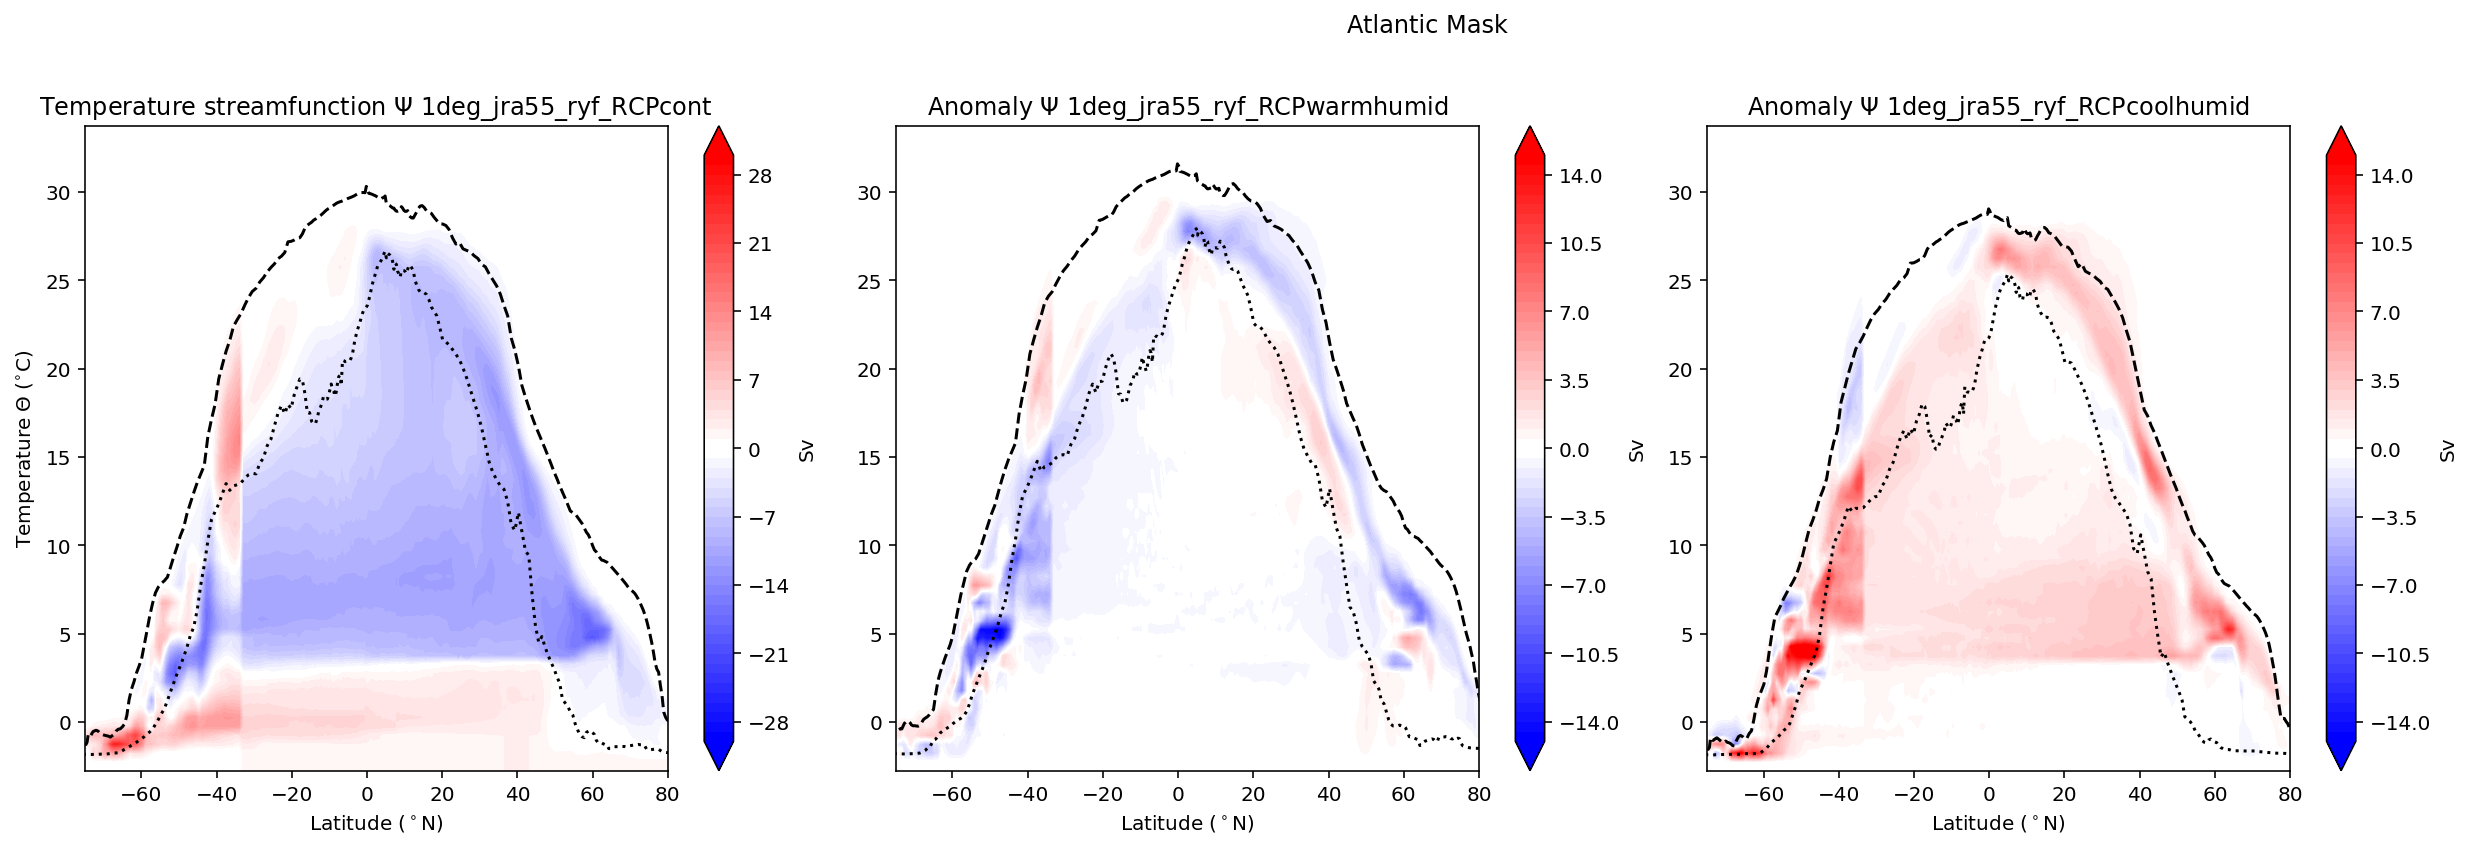

In [147]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize = (20,6))
plt.suptitle('Atlantic Mask')
expt = '1deg_jra55_ryf_RCPcont'
n=21
bwr_custom = custom_div_cmap(59)
clev = np.linspace(-30,30,61)
#clev = np.arange(-1.5,1.55,0.125)
cs = axes[0].contourf(psi_avg_contatlantic.grid_yu_ocean,psi_avg_contatlantic.neutral, psi_avg_contatlantic, cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True)
SST_min.plot(color = 'k', linestyle = 'dotted', ax = axes[0])
SST_max.plot(color = 'k', linestyle = '--', ax = axes[0])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
axes[0].set_ylabel('Temperature $\Theta $ ($^{\circ}$C)')
axes[0].set_xlabel('Latitude ($^\circ$N)')
axes[0].set_xlim([-75,80])
axes[0].set_title('Temperature streamfunction $\Psi$ %s' % expt);
fig.colorbar(cs, ax=axes[0], label = 'Sv')
#plt.savefig('figures/overturning')
bwr_custom = custom_div_cmap(19)
expt = '1deg_jra55_ryf_RCPwarmhumid'

#clev = np.arange(-0.5,0.52,0.05)
bwr_custom = custom_div_cmap(59)
clev = np.linspace(-15,15,61)
cs2 = axes[1].contourf((psi_avg_contatlanticw-psi_avg_contatlantic).grid_yu_ocean,(psi_avg_contatlanticw-psi_avg_contatlantic).neutral, (psi_avg_contatlanticw-psi_avg_contatlantic), cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True)
SST_min_w.plot(color = 'k', linestyle = 'dotted', ax = axes[1])
SST_max_w.plot(color = 'k', linestyle = '--', ax = axes[1])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
axes[1].set_ylabel('')
axes[1].set_xlabel('Latitude ($^\circ$N)')
axes[1].set_xlim([-75,80])
axes[1].set_title('Anomaly $\Psi$ %s' % expt);
fig.colorbar(cs2, ax=axes[1], label = 'Sv')

expt = '1deg_jra55_ryf_RCPcoolhumid'

#clev = np.arange(-0.5,0.52,0.05)
cs3 = axes[2].contourf((psi_avg_contatlanticco-psi_avg_contatlantic).grid_yu_ocean,(psi_avg_contatlanticco-psi_avg_contatlantic).neutral, (psi_avg_contatlanticco-psi_avg_contatlantic), cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True, vcenter=0)
SST_min_co.plot(color = 'k', linestyle = 'dotted', ax = axes[2])
SST_max_co.plot(color = 'k', linestyle = '--', ax = axes[2])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
axes[2].set_ylabel('')
axes[2].set_xlabel('Latitude ($^\circ$N)')
axes[2].set_xlim([-75,80])
axes[2].set_title('Anomaly $\Psi$ %s' % expt);
fig.colorbar(cs3, ax=axes[2], label = 'Sv')


# cb_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
# cbar = fig.colorbar(CS, cax=cb_ax, cmap = cm.cm.balance)
# cbar.ax.set_ylabel('heat anomaly ($Jm^{-2}$)', fontsize = 16)
plt.tight_layout()
plt.subplots_adjust(top=0.85, right = 0.85, hspace = 0.25)

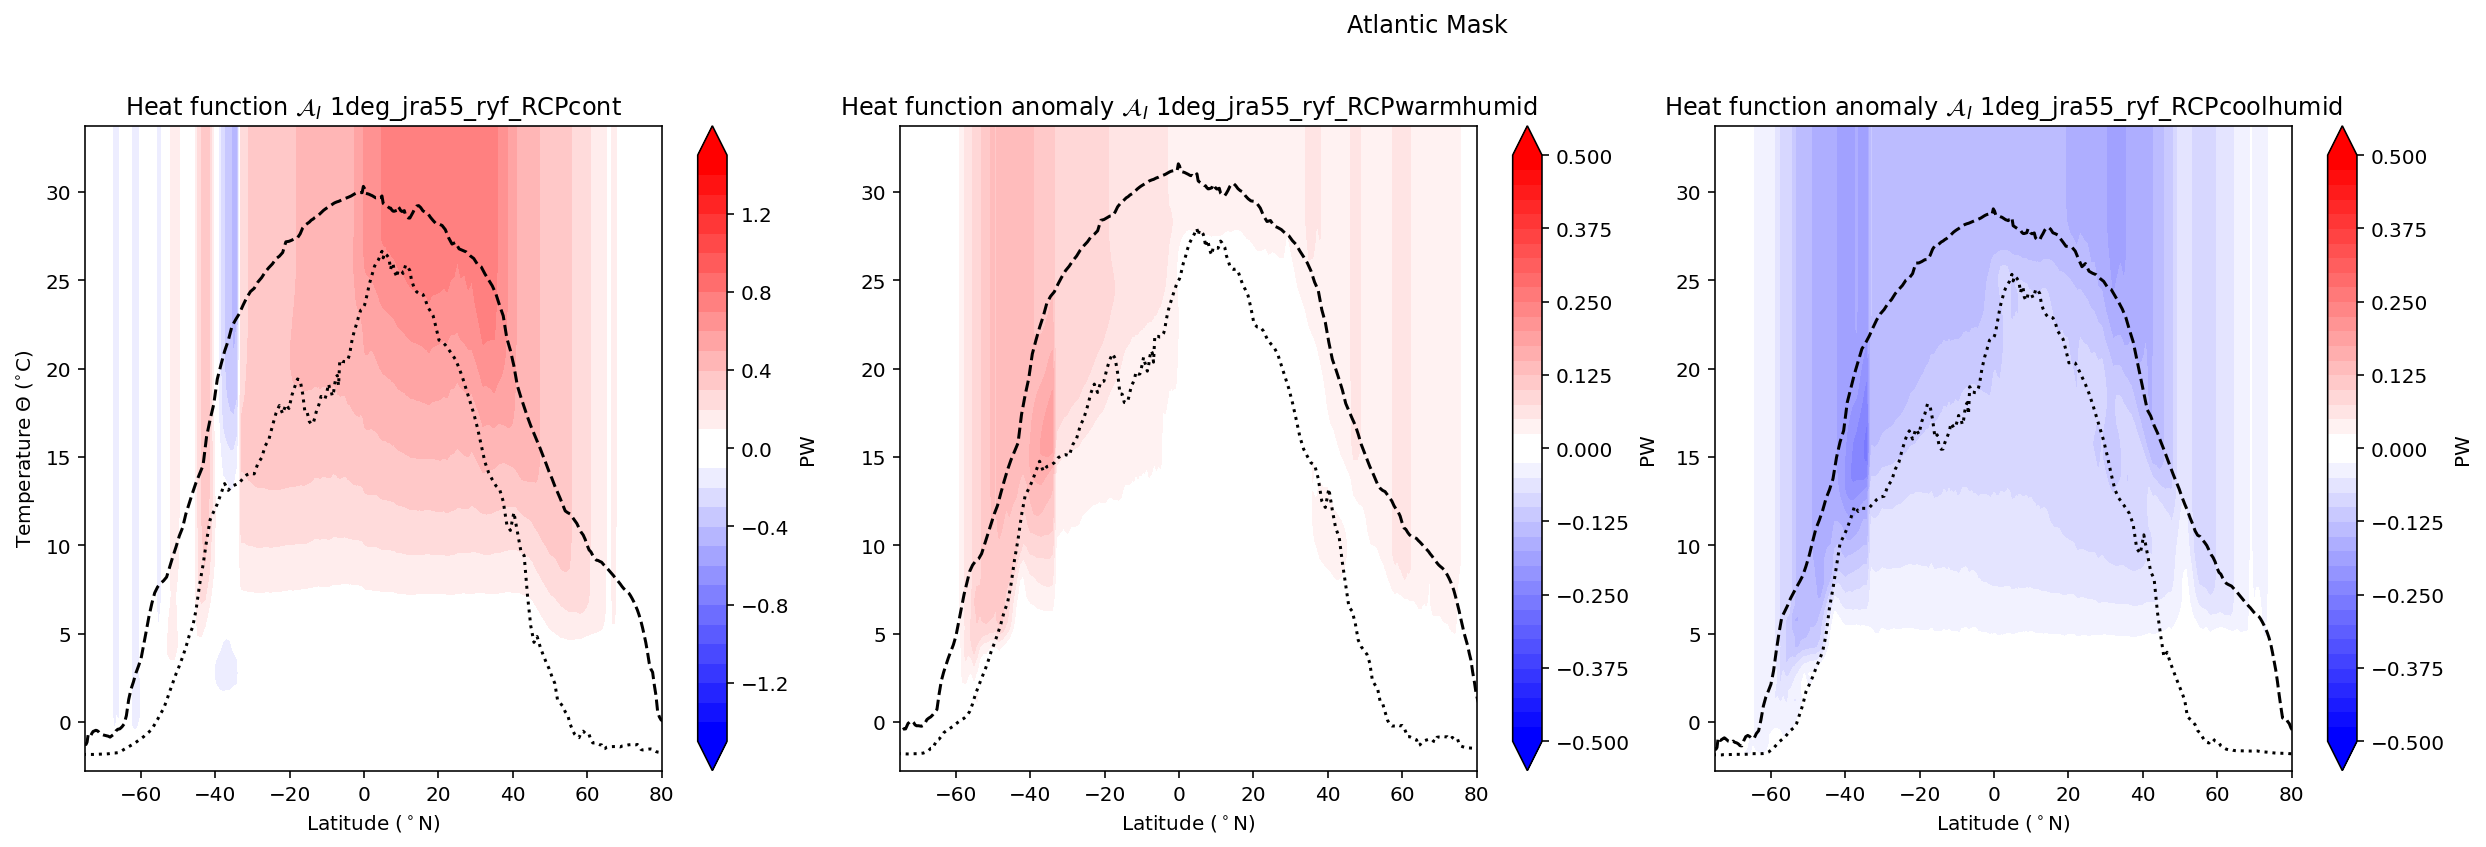

In [152]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize = (20,6))
plt.suptitle('Atlantic Mask')
expt = '1deg_jra55_ryf_RCPcont'
bwr_custom = custom_div_cmap(29)
clev = np.linspace(-1.5,1.5,31)
#clev = np.arange(-1.5,1.51,0.125)
cs = axes[0].contourf(A_I_contatlantic.grid_yu_ocean,A_I_contatlantic.neutral, A_I_contatlantic, cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True)
SST_min.plot(color = 'k', linestyle = 'dotted', ax = axes[0])
SST_max.plot(color = 'k', linestyle = '--', ax = axes[0])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
axes[0].set_ylabel('Temperature $\Theta $ ($^{\circ}$C)')
axes[0].set_xlabel('Latitude ($^\circ$N)')
axes[0].set_xlim([-75,80])
axes[0].set_title('Heat function $\mathcal{A}_I$ %s' % expt);
fig.colorbar(cs, ax=axes[0], label = 'PW')
#plt.savefig('figures/overturning')

expt = '1deg_jra55_ryf_RCPwarmhumid'
bwr_custom = custom_div_cmap(39)
clev = np.linspace(-0.5,0.5,41)

#clev = np.arange(-0.5,0.51,0.05)
cs2 = axes[1].contourf((A_I_contatlanticw-A_I_contatlantic).grid_yu_ocean,(A_I_contatlanticw-A_I_contatlantic).neutral, (A_I_contatlanticw-A_I_contatlantic), cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True)
SST_min_w.plot(color = 'k', linestyle = 'dotted', ax = axes[1])
SST_max_w.plot(color = 'k', linestyle = '--', ax = axes[1])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
axes[1].set_ylabel('')
axes[1].set_xlabel('Latitude ($^\circ$N)')
axes[1].set_xlim([-75,80])
axes[1].set_title('Heat function anomaly $\mathcal{A}_I$ %s' % expt);
fig.colorbar(cs2, ax=axes[1], label = 'PW')

expt = '1deg_jra55_ryf_RCPcoolhumid'

#clev = np.arange(-0.5,0.51,0.05)
cs3 = axes[2].contourf((A_I_contatlanticco-A_I_contatlantic).grid_yu_ocean,(A_I_contatlanticco-A_I_contatlantic).neutral, (A_I_contatlanticco-A_I_contatlantic), cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True)
SST_min_co.plot(color = 'k', linestyle = 'dotted', ax = axes[2])
SST_max_co.plot(color = 'k', linestyle = '--', ax = axes[2])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
axes[2].set_ylabel('')
axes[2].set_xlabel('Latitude ($^\circ$N)')
axes[2].set_xlim([-75,80])
axes[2].set_title('Heat function anomaly $\mathcal{A}_I$ %s' % expt);
fig.colorbar(cs3, ax=axes[2], label = 'PW')


# cb_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
# cbar = fig.colorbar(CS, cax=cb_ax, cmap = cm.cm.balance)
# cbar.ax.set_ylabel('heat anomaly ($Jm^{-2}$)', fontsize = 16)
plt.tight_layout()
plt.subplots_adjust(top=0.85, right = 0.85, hspace = 0.25)

# Indo-Pacific

In [157]:
expt = '1deg_jra55_ryf_RCPcont'
start_time='2910-01-31'
end_time = '2950-01-01'

psi = cc.querying.getvar(expt,'ty_trans_nrho',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time)
psi = psi*indo_sector_mask#.isel(time = np.arange(40,50))
#psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',chunks={'potrho': None}, n=-10)
psi = psi.sum('grid_xt_ocean')

# ty_trans_nrho -> transport within temperature intervals 
# neutral_rho, neutral.
#

varlist = cc.querying.get_variables(session, expt)
if varlist['name'].str.contains('ty_trans_nrho_gm').any():
    GM = True
    psiGM = cc.querying.getvar(expt,'ty_trans_nrho_gm',session,start_time = start_time, end_time = end_time)#.isel(time = np.arange(40,50))
    psiGM = (psiGM*indo_sector_mask).sum('grid_xt_ocean')
    psisubmeso = cc.querying.getvar(expt,'ty_trans_nrho_submeso',session,start_time = start_time, end_time = end_time)#.isel(time = np.arange(40,50))
    psisubmeso = (psisubmeso*indo_sector_mask).sum('grid_xt_ocean')

else:
    GM = False
    
rho = 1025 # mean density of sea-water in kg/m^3
psi = psi / (1e6*rho) # converts kg/s to Sv
if GM:
    psiGM = psiGM / (1e6*rho)
    psisubmeso = psisubmeso / (1e6*rho)
    

psi_avg_contindo = psi.cumsum('neutral').mean('time') - psi.sum('neutral').mean('time')
if GM:
    psi_avg_contindo = psi_avg_contindo + psiGM.mean('time')+ psisubmeso.mean('time')
    
psi_avg_contindo.load()


SST_max_contindo = cc.querying.getvar(expt,'temp',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time).isel(st_ocean = 0).max('time').max('xt_ocean') -273.15#.isel(time = np.arange(40,50))
SST_min_contindo = cc.querying.getvar(expt,'temp',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time).isel(st_ocean = 0).min('time').min('xt_ocean') -273.15
    
    

rho_0 = 1030#kg/m^3
c_p = 3992 
A_I_contindo= -rho_0*c_p*psi_avg_contindo.cumsum('neutral')*0.5 #(0.5 is size of d\theta)
A_I_contindo = A_I_contindo/10**9 # convert to PW
#A_I_contindo= (A_I_contindo).where(psi_avg_contindo!=0).fillna(0)

In [158]:
expt = '1deg_jra55_ryf_RCPwarmhumid'
start_time='2910-01-31'
end_time = '2950-01-01'

psi = cc.querying.getvar(expt,'ty_trans_nrho',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time)
psi = psi*indo_sector_mask#.isel(time = np.arange(40,50))
#psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',chunks={'potrho': None}, n=-10)
psi = psi.sum('grid_xt_ocean')

# ty_trans_nrho -> transport within temperature intervals 
# neutral_rho, neutral.
#

varlist = cc.querying.get_variables(session, expt)
if varlist['name'].str.contains('ty_trans_nrho_gm').any():
    GM = True
    psiGM = cc.querying.getvar(expt,'ty_trans_nrho_gm',session,start_time = start_time, end_time = end_time)#.isel(time = np.arange(40,50))
    psiGM = (psiGM*indo_sector_mask).sum('grid_xt_ocean')
    psisubmeso = cc.querying.getvar(expt,'ty_trans_nrho_submeso',session,start_time = start_time, end_time = end_time)#.isel(time = np.arange(40,50))
    psisubmeso = (psisubmeso*indo_sector_mask).sum('grid_xt_ocean')

else:
    GM = False
    
rho = 1025 # mean density of sea-water in kg/m^3
psi = psi / (1e6*rho) # converts kg/s to Sv
if GM:
    psiGM = psiGM / (1e6*rho)
    psisubmeso = psisubmeso / (1e6*rho)
    

psi_avg_contindow = psi.cumsum('neutral').mean('time') - psi.sum('neutral').mean('time')
if GM:
    psi_avg_contindow = psi_avg_contindow + psiGM.mean('time')+ psisubmeso.mean('time')
    
psi_avg_contindow.load()


SST_max_contindow = cc.querying.getvar(expt,'temp',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time).isel(st_ocean = 0).max('time').max('xt_ocean') -273.15#.isel(time = np.arange(40,50))
SST_min_contindow = cc.querying.getvar(expt,'temp',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time).isel(st_ocean = 0).min('time').min('xt_ocean') -273.15
    
    

rho_0 = 1030#kg/m^3
c_p = 3992 
A_I_contindow= -rho_0*c_p*psi_avg_contindow.cumsum('neutral')*0.5 #(0.5 is size of d\theta)
A_I_contindow = A_I_contindow/10**9 # convert to PW
#A_I_contindo= (A_I_contindo).where(psi_avg_contindo!=0).fillna(0)

In [159]:
expt = '1deg_jra55_ryf_RCPcoolhumid'
start_time='2910-01-31'
end_time = '2950-01-01'

psi = cc.querying.getvar(expt,'ty_trans_nrho',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time)
psi = psi*indo_sector_mask#.isel(time = np.arange(40,50))
#psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',chunks={'potrho': None}, n=-10)
psi = psi.sum('grid_xt_ocean')

# ty_trans_nrho -> transport within temperature intervals 
# neutral_rho, neutral.
#

varlist = cc.querying.get_variables(session, expt)
if varlist['name'].str.contains('ty_trans_nrho_gm').any():
    GM = True
    psiGM = cc.querying.getvar(expt,'ty_trans_nrho_gm',session,start_time = start_time, end_time = end_time)#.isel(time = np.arange(40,50))
    psiGM = (psiGM*indo_sector_mask).sum('grid_xt_ocean')
    psisubmeso = cc.querying.getvar(expt,'ty_trans_nrho_submeso',session,start_time = start_time, end_time = end_time)#.isel(time = np.arange(40,50))
    psisubmeso = (psisubmeso*indo_sector_mask).sum('grid_xt_ocean')

else:
    GM = False
    
rho = 1025 # mean density of sea-water in kg/m^3
psi = psi / (1e6*rho) # converts kg/s to Sv
if GM:
    psiGM = psiGM / (1e6*rho)
    psisubmeso = psisubmeso / (1e6*rho)
    

psi_avg_contindoco = psi.cumsum('neutral').mean('time') - psi.sum('neutral').mean('time')
if GM:
    psi_avg_contindoco = psi_avg_contindoco + psiGM.mean('time')+ psisubmeso.mean('time')
    
psi_avg_contindoco.load()


SST_max_contindoco = cc.querying.getvar(expt,'temp',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time).isel(st_ocean = 0).max('time').max('xt_ocean') -273.15#.isel(time = np.arange(40,50))
SST_min_contindoco = cc.querying.getvar(expt,'temp',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time).isel(st_ocean = 0).min('time').min('xt_ocean') -273.15
    
    

rho_0 = 1030#kg/m^3
c_p = 3992 
A_I_contindoco= -rho_0*c_p*psi_avg_contindoco.cumsum('neutral')*0.5 #(0.5 is size of d\theta)
A_I_contindoco = A_I_contindoco/10**9 # convert to PW
#A_I_contindo= (A_I_contindo).where(psi_avg_contindo!=0).fillna(0)

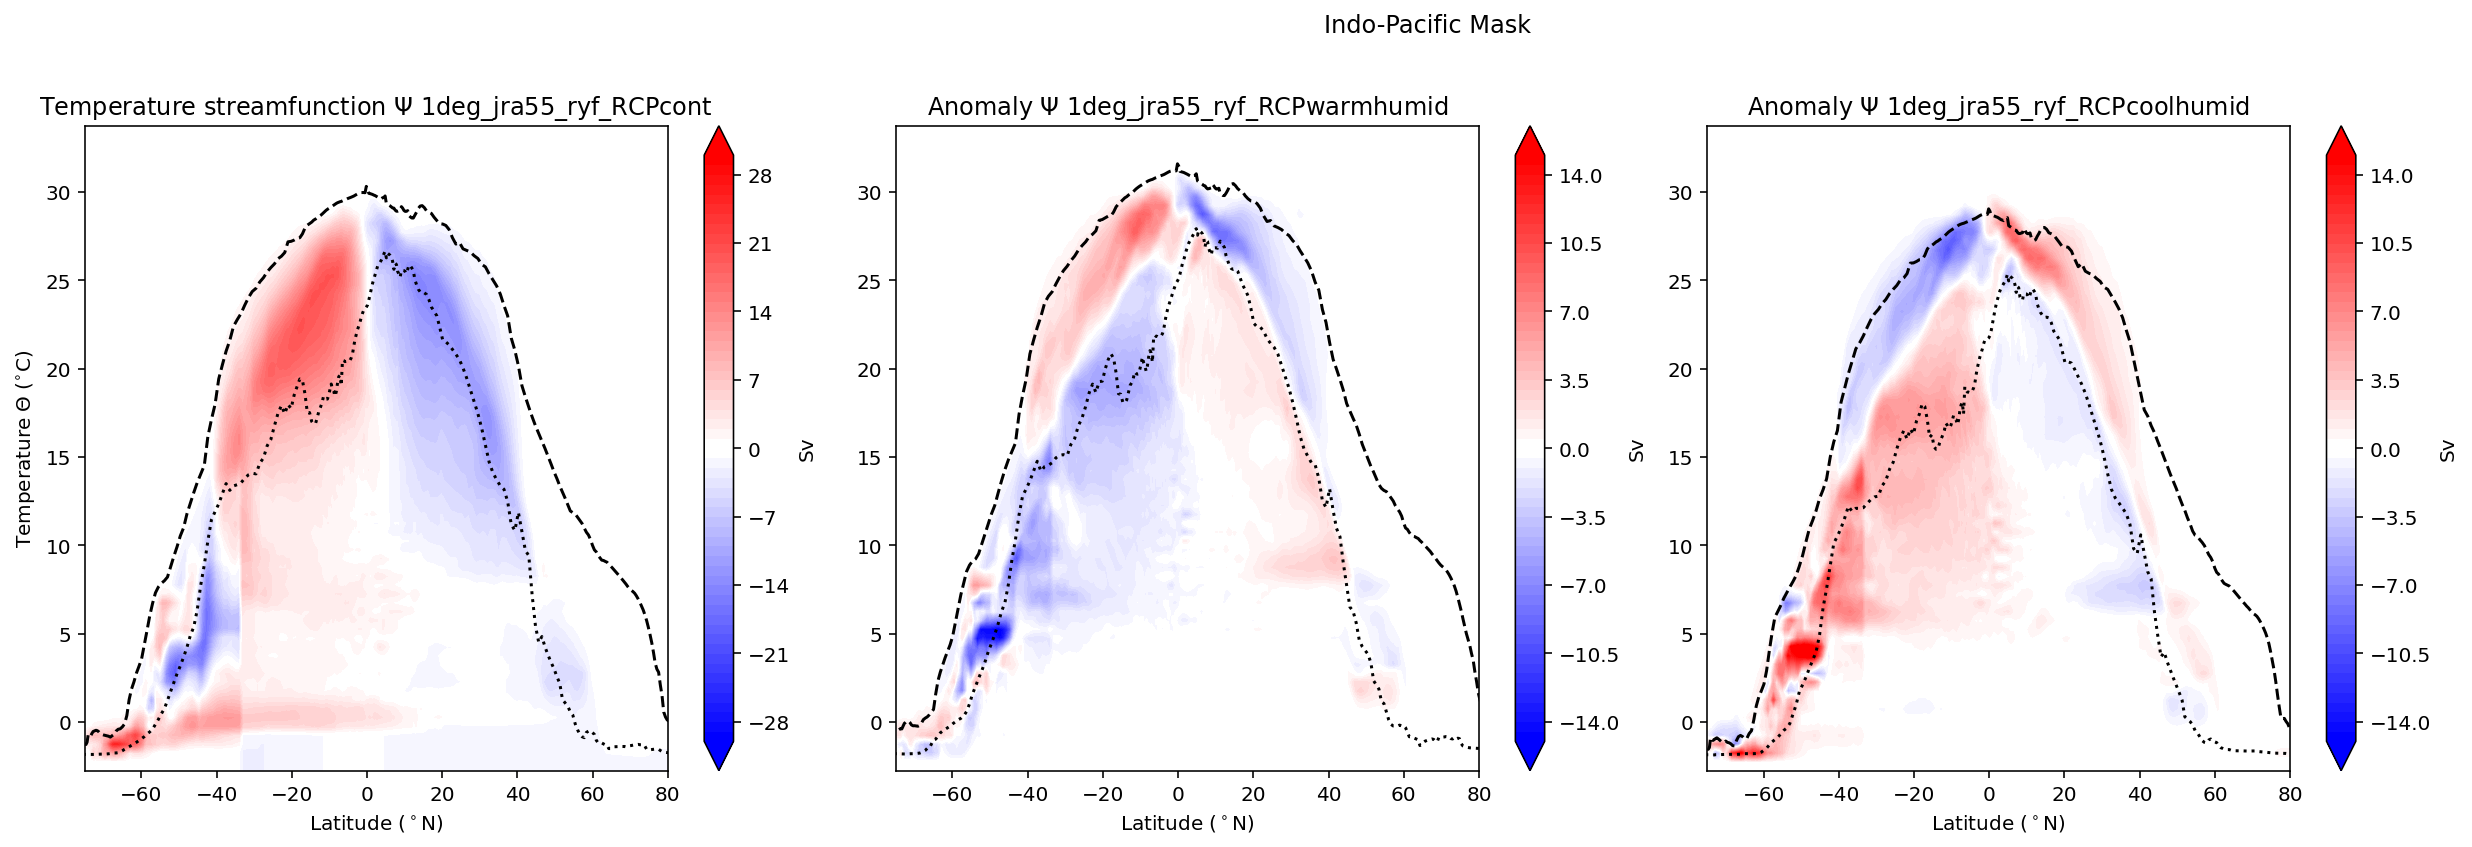

In [160]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize = (20,6))
plt.suptitle('Indo-Pacific Mask')
expt = '1deg_jra55_ryf_RCPcont'
n=21
bwr_custom = custom_div_cmap(59)
clev = np.linspace(-30,30,61)
#clev = np.arange(-1.5,1.55,0.125)
cs = axes[0].contourf(psi_avg_contindo.grid_yu_ocean,psi_avg_contindo.neutral, psi_avg_contindo, cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True)
SST_min.plot(color = 'k', linestyle = 'dotted', ax = axes[0])
SST_max.plot(color = 'k', linestyle = '--', ax = axes[0])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
axes[0].set_ylabel('Temperature $\Theta $ ($^{\circ}$C)')
axes[0].set_xlabel('Latitude ($^\circ$N)')
axes[0].set_xlim([-75,80])
axes[0].set_title('Temperature streamfunction $\Psi$ %s' % expt);
fig.colorbar(cs, ax=axes[0], label = 'Sv')
#plt.savefig('figures/overturning')
bwr_custom = custom_div_cmap(19)
expt = '1deg_jra55_ryf_RCPwarmhumid'

#clev = np.arange(-0.5,0.52,0.05)
bwr_custom = custom_div_cmap(59)
clev = np.linspace(-15,15,61)
cs2 = axes[1].contourf((psi_avg_contindow-psi_avg_contindo).grid_yu_ocean,(psi_avg_contindow-psi_avg_contindo).neutral, (psi_avg_contindow-psi_avg_contindo), cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True)
SST_min_w.plot(color = 'k', linestyle = 'dotted', ax = axes[1])
SST_max_w.plot(color = 'k', linestyle = '--', ax = axes[1])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
axes[1].set_ylabel('')
axes[1].set_xlabel('Latitude ($^\circ$N)')
axes[1].set_xlim([-75,80])
axes[1].set_title('Anomaly $\Psi$ %s' % expt);
fig.colorbar(cs2, ax=axes[1], label = 'Sv')

expt = '1deg_jra55_ryf_RCPcoolhumid'

#clev = np.arange(-0.5,0.52,0.05)
cs3 = axes[2].contourf((psi_avg_contindoco-psi_avg_contindo).grid_yu_ocean,(psi_avg_contindoco-psi_avg_contindo).neutral, (psi_avg_contindoco-psi_avg_contindo), cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True, vcenter=0)
SST_min_co.plot(color = 'k', linestyle = 'dotted', ax = axes[2])
SST_max_co.plot(color = 'k', linestyle = '--', ax = axes[2])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
axes[2].set_ylabel('')
axes[2].set_xlabel('Latitude ($^\circ$N)')
axes[2].set_xlim([-75,80])
axes[2].set_title('Anomaly $\Psi$ %s' % expt);
fig.colorbar(cs3, ax=axes[2], label = 'Sv')


# cb_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
# cbar = fig.colorbar(CS, cax=cb_ax, cmap = cm.cm.balance)
# cbar.ax.set_ylabel('heat anomaly ($Jm^{-2}$)', fontsize = 16)
plt.tight_layout()
plt.subplots_adjust(top=0.85, right = 0.85, hspace = 0.25)

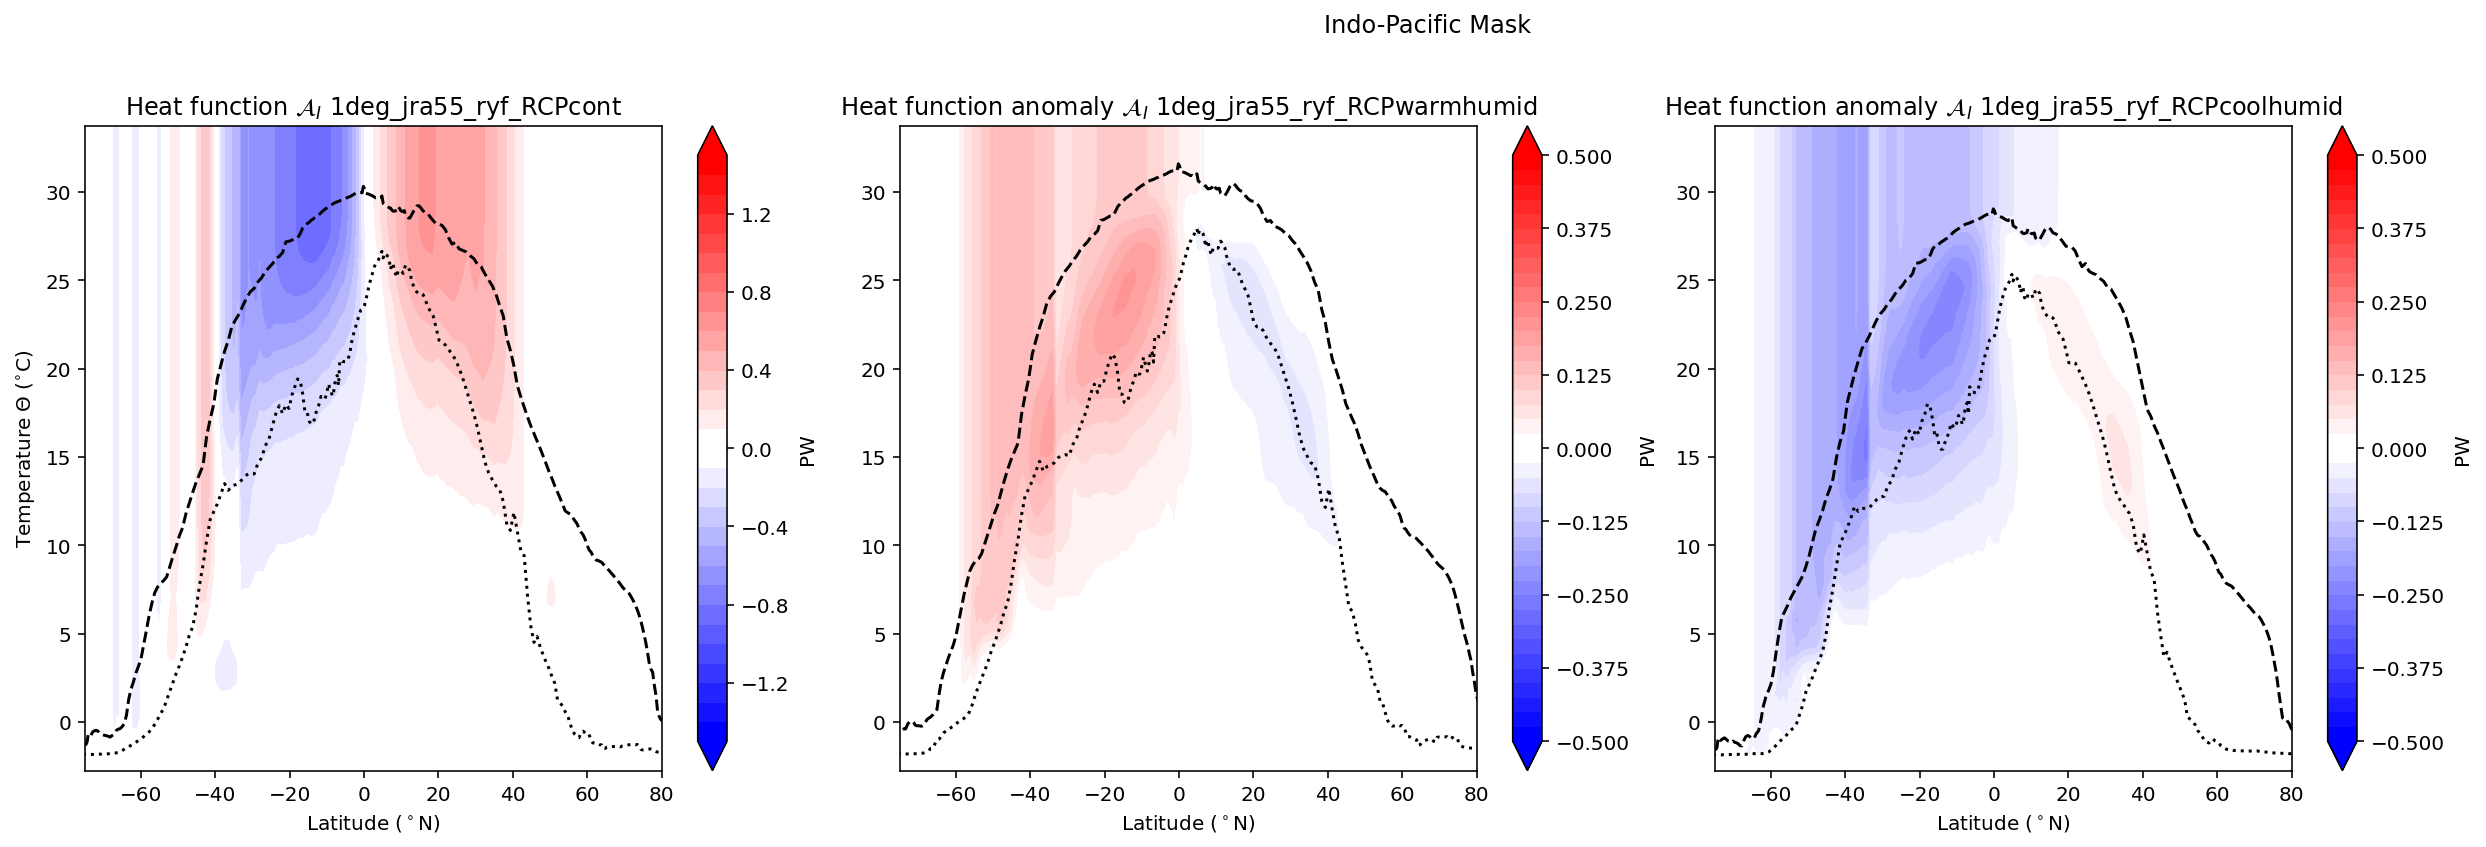

In [161]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize = (20,6))
plt.suptitle('Indo-Pacific Mask')
expt = '1deg_jra55_ryf_RCPcont'
bwr_custom = custom_div_cmap(29)
clev = np.linspace(-1.5,1.5,31)
#clev = np.arange(-1.5,1.51,0.125)
cs = axes[0].contourf(A_I_contindo.grid_yu_ocean,A_I_contindo.neutral, A_I_contindo, cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True)
SST_min.plot(color = 'k', linestyle = 'dotted', ax = axes[0])
SST_max.plot(color = 'k', linestyle = '--', ax = axes[0])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
axes[0].set_ylabel('Temperature $\Theta $ ($^{\circ}$C)')
axes[0].set_xlabel('Latitude ($^\circ$N)')
axes[0].set_xlim([-75,80])
axes[0].set_title('Heat function $\mathcal{A}_I$ %s' % expt);
fig.colorbar(cs, ax=axes[0], label = 'PW')
#plt.savefig('figures/overturning')

expt = '1deg_jra55_ryf_RCPwarmhumid'
bwr_custom = custom_div_cmap(39)
clev = np.linspace(-0.5,0.5,41)

#clev = np.arange(-0.5,0.51,0.05)
cs2 = axes[1].contourf((A_I_contindow-A_I_contindo).grid_yu_ocean,(A_I_contindow-A_I_contindo).neutral, (A_I_contindow-A_I_contindo), cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True)
SST_min_w.plot(color = 'k', linestyle = 'dotted', ax = axes[1])
SST_max_w.plot(color = 'k', linestyle = '--', ax = axes[1])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
axes[1].set_ylabel('')
axes[1].set_xlabel('Latitude ($^\circ$N)')
axes[1].set_xlim([-75,80])
axes[1].set_title('Heat function anomaly $\mathcal{A}_I$ %s' % expt);
fig.colorbar(cs2, ax=axes[1], label = 'PW')

expt = '1deg_jra55_ryf_RCPcoolhumid'

#clev = np.arange(-0.5,0.51,0.05)
cs3 = axes[2].contourf((A_I_contindoco-A_I_contindo).grid_yu_ocean,(A_I_contindoco-A_I_contindo).neutral, (A_I_contindoco-A_I_contindo), cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True)
SST_min_co.plot(color = 'k', linestyle = 'dotted', ax = axes[2])
SST_max_co.plot(color = 'k', linestyle = '--', ax = axes[2])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
axes[2].set_ylabel('')
axes[2].set_xlabel('Latitude ($^\circ$N)')
axes[2].set_xlim([-75,80])
axes[2].set_title('Heat function anomaly $\mathcal{A}_I$ %s' % expt);
fig.colorbar(cs3, ax=axes[2], label = 'PW')


# cb_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
# cbar = fig.colorbar(CS, cax=cb_ax, cmap = cm.cm.balance)
# cbar.ax.set_ylabel('heat anomaly ($Jm^{-2}$)', fontsize = 16)
plt.tight_layout()
plt.subplots_adjust(top=0.85, right = 0.85, hspace = 0.25)

it appears that the subsurface warming in the northern hemisphere is from the indo-Pacific not atlantic. In Atlantic changes are consistent with AMOC.

Missing first 10 years so can't see onset of AMOC changes.


# define functions to make life easier:

In [173]:
    def heatfunc(ekey,start_time,end_time, mask):
        expt = exptdict[ekey]['expt']

        if mask == None:
            psi = cc.querying.getvar(expt,'ty_trans_nrho',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time).sel(time = slice(start_time,end_time))
            psi = psi.sum('grid_xt_ocean')
            
            psiGM = cc.querying.getvar(expt,'ty_trans_nrho_gm',session,start_time = start_time, end_time = end_time).sel(time = slice(start_time,end_time))
            psiGM = (psiGM).sum('grid_xt_ocean')
            psisubmeso = cc.querying.getvar(expt,'ty_trans_nrho_submeso',session,start_time = start_time, end_time = end_time).sel(time = slice(start_time,end_time))
            psisubmeso = (psisubmeso).sum('grid_xt_ocean')
            
        else:
            
            psi = cc.querying.getvar(expt,'ty_trans_nrho',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time).sel(time = slice(start_time,end_time))
            psi = psi*mask
            psi = psi.sum('grid_xt_ocean')
            psiGM = cc.querying.getvar(expt,'ty_trans_nrho_gm',session,start_time = start_time, end_time = end_time).sel(time = slice(start_time,end_time))
            psiGM = (psiGM*mask).sum('grid_xt_ocean')
            psisubmeso = cc.querying.getvar(expt,'ty_trans_nrho_submeso',session,start_time = start_time, end_time = end_time).sel(time = slice(start_time,end_time))
            psisubmeso = (psisubmeso*mask).sum('grid_xt_ocean')

    
        rho = 1025 # mean density of sea-water in kg/m^3
        psi = psi / (1e6*rho) # converts kg/s to Sv
        psiGM = psiGM / (1e6*rho)
        psisubmeso = psisubmeso / (1e6*rho)

        psi_avg = psi.cumsum('neutral').mean('time') - psi.sum('neutral').mean('time')
        psi_avg = psi_avg + psiGM.mean('time')+ psisubmeso.mean('time')
        psi_avg.load()

        SST_max = cc.querying.getvar(expt,'temp',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time).isel(st_ocean = 0).max('time').max('xt_ocean') -273.15#.isel(time = np.arange(40,50))
        SST_min = cc.querying.getvar(expt,'temp',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time).isel(st_ocean = 0).min('time').min('xt_ocean') -273.15
    
    

        rho_0 = 1030#kg/m^3
        c_p = 3992 
        A_I = -rho_0*c_p*psi_avg.cumsum('neutral')*0.5 #(0.5 is size of d\theta)
        A_I = A_I/10**9 # convert to PW
        #A_I_contatlantic= (A_I_contatlantic).where(psi_avg_contatlantic!=0).fillna(0)
        return psi_avg, A_I

In [174]:
exptdict = OrderedDict([
    ('Control',  {'expt':'1deg_jra55_ryf_RCPcont'}),
    ('Warming',  {'expt':'1deg_jra55_ryf_RCPwarmhumid'}),
    ('Warming x2',  {'expt':'1deg_jra55_ryf_RCPwarmhumid2x'}),
    ('Cooling',  {'expt':'1deg_jra55_ryf_RCPcoolhumid'}),
    ('Cooling x2',  {'expt':'1deg_jra55_ryf_RCPcoolhumid2x'}),
    ('Warming w/o humidity',  {'expt':'1deg_jra55_ryf_rcpwarm'}),
    ('Cooling w/o humidity',  {'expt':'1deg_jra55_ryf_rcpcool'}),
    ('Cooling w/o humidity2', {'expt':'1deg_jra55_ryf_RCPcool'}),
    ('Windup', {'expt':'1deg_jra55_ryf_red3DSK_C9'})

])

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize = (20,6))
start_time = '2900-01-01'
end_time = '2910-01-01'
basin = None
psi_avg_cont, A_I_cont = heatfunc('Control',start_time,end_time, basin)
psi_avg_warm, A_I_warm = heatfunc('Warming x2',start_time,end_time, basin)
psi_avg_cool, A_I_cool = heatfunc('Cooling x2',start_time,end_time, basin)
plt.suptitle('Basin:'+str(basin)+'    Year'+start_time+'to'+end_time)
expt = '1deg_jra55_ryf_RCPcont'
n=21
bwr_custom = custom_div_cmap(59)
clev = np.linspace(-30,30,61)
#clev = np.arange(-1.5,1.55,0.125)
cs = axes[0].contourf(psi_avg_cont.grid_yu_ocean,psi_avg_cont.neutral, psi_avg_cont, cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True)
SST_min.plot(color = 'k', linestyle = 'dotted', ax = axes[0])
SST_max.plot(color = 'k', linestyle = '--', ax = axes[0])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
axes[0].set_ylabel('Temperature $\Theta $ ($^{\circ}$C)')
axes[0].set_xlabel('Latitude ($^\circ$N)')
axes[0].set_xlim([-75,80])
axes[0].set_title('Temperature streamfunction $\Psi$ %s' % expt);
fig.colorbar(cs, ax=axes[0], label = 'Sv')
#plt.savefig('figures/overturning')
bwr_custom = custom_div_cmap(19)
expt = '1deg_jra55_ryf_RCPwarmhumid2x'

#clev = np.arange(-0.5,0.52,0.05)
bwr_custom = custom_div_cmap(59)
clev = np.linspace(-30,30,61)
cs2 = axes[1].contourf((psi_avg_warm-psi_avg_cont).grid_yu_ocean,(psi_avg_warm-psi_avg_cont).neutral, (psi_avg_warm-psi_avg_cont), cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True)
SST_min_w.plot(color = 'k', linestyle = 'dotted', ax = axes[1])
SST_max_w.plot(color = 'k', linestyle = '--', ax = axes[1])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
axes[1].set_ylabel('')
axes[1].set_xlabel('Latitude ($^\circ$N)')
axes[1].set_xlim([-75,80])
axes[1].set_title('Anomaly $\Psi$ %s' % expt);
fig.colorbar(cs2, ax=axes[1], label = 'Sv')

expt = '1deg_jra55_ryf_RCPcoolhumid2x'

#clev = np.arange(-0.5,0.52,0.05)
cs3 = axes[2].contourf((psi_avg_cool-psi_avg_cont).grid_yu_ocean,(psi_avg_cool-psi_avg_cont).neutral, (psi_avg_cool-psi_avg_cont), cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True, vcenter=0)
SST_min_co.plot(color = 'k', linestyle = 'dotted', ax = axes[2])
SST_max_co.plot(color = 'k', linestyle = '--', ax = axes[2])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
axes[2].set_ylabel('')
axes[2].set_xlabel('Latitude ($^\circ$N)')
axes[2].set_xlim([-75,80])
axes[2].set_title('Anomaly $\Psi$ %s' % expt);
fig.colorbar(cs3, ax=axes[2], label = 'Sv')


# cb_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
# cbar = fig.colorbar(CS, cax=cb_ax, cmap = cm.cm.balance)
# cbar.ax.set_ylabel('heat anomaly ($Jm^{-2}$)', fontsize = 16)
plt.tight_layout()
plt.subplots_adjust(top=0.85, right = 0.85, hspace = 0.25)